In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/Kolmogorov


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
from tools.ae_v2 import Autoencoder
from tools.ConvESN_v3_AR import ESN as AR_RNN_ESN
from tools.AEConvESN_AR_v1 import AR_AERNN_ESN
from tools.trainAERNN import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-02-20 20:00:20.193312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 20:00:20.193661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 20:00:20.226489: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 20:00:20.226847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-20 20:00:20.227056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_ConvESN/ESN_007'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AERNN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_rnn_014'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_RNN_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_ESN/ESN_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in AR_RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in AR_RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in AR_RNN_specific_data, set to True.")
        use_ae_data = True
    try:
        normalization_type = params_AR_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in AR_RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    covmat_lmda = tparams_dict['covmat_lmda']
    try:
        lambda_reg = tparams_dict['lambda_reg']
    except:
        lambda_reg = 1e-6
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None
    if 'freeze_layers' in tparams_dict.keys():
        freeze_layers = tparams_dict['freeze_layers']
    else:
        freeze_layers = None
    if 'clipnorm' in tparams_dict.keys():
        clipnorm = tparams_dict['clipnorm']
    else:
        clipnorm = None
    


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']

with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
    normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('data_dir_idx:', data_dir_idx)
print('dir_name_rnn:', dir_name_rnn)
print('use_ae_data : ' + str(use_ae_data) + ', dir_name_ae:', dir_name_ae)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx

with h5py.File(dir_name_data + '/data.h5', 'r') as f:
    t_recorded_samples = np.array(f['t'])
    
    N = int(0.5*(np.array(f['num_wavenumbers'])-1))
    print(N, type(N))
    
    u_ref = np.array(f['u_reference'], dtype=FTYPE)
    v_ref = np.array(f['v_reference'], dtype=FTYPE)


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003
data_dir_idx: 000
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ConvESN/ESN_007
use_ae_data : True, dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_013
24 <class 'int'>


In [12]:
all_data = np.empty(shape=(u_ref.shape[0], 2, u_ref.shape[1], u_ref.shape[2]), dtype=FTYPE)
all_data[:, 0, :, :] = u_ref
del(u_ref)
all_data[:, 1, :, :] = v_ref
del(v_ref)

In [13]:
lyap_time = 1/0.065
delta_t = 1.
T = t_recorded_samples[-1]

In [14]:
print('all_data.shape : {}'.format(all_data.shape))

all_data.shape : (100001, 2, 50, 50)


In [15]:
all_data = all_data[0:int(all_data.shape[0]/3)]

In [16]:
print('all_data.shape : {}'.format(all_data.shape))

all_data.shape : (33333, 2, 50, 50)


# Autoencoder

In [17]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [18]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# ESN

In [19]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([5, 10, 30, 50])*dt_rnn/lyap_time
    num_timesteps_warmup = 1*lyap_time/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*lyap_time
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        # 'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN_ESN.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [20]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [2e-5],
        [1e-5],
        [2e-6],
        [1e-6],
    ]
    epochs = [
        [1000],
        [1000],
        [1000],
        [1000],
    ]
    patience = [
        [50],
        [50],
        [50],
        [50],
    ] # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-6  # weight for regularizer
    covmat_lmda = 1e-3  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
        
    freeze_layers = [
        [],
        [],
        [],
    ]
    
    clipnorm = None #1.0
    batch_size = 16
    
    train_alpha = [False]*3
    train_omega_in = [False]*3
    train_rho_res = [False]*3
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
        'freeze_layers':freeze_layers,
        'clipnorm':clipnorm,
        'lambda_reg':lambda_reg,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [21]:
rnn_kwargs = {}
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_ESN_weights.hdf5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'
    
    rnn_kwargs = {
        'train_alpha':train_alpha,
        'train_omega_in':train_omega_in,
        'train_rho_res':train_rho_res,
    }

In [22]:
%pdb

Automatic pdb calling has been turned ON




********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 5 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : None


2023-02-20 20:00:29.126627: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


(497, 62, 5000) (497, 5, 5000)
init Wres made : 24.38500428199768 s.
Wres pp dealt with : 69.21019315719604 s.
sparse Wres made : 118.48548436164856 s.
spectral radius found : 214.61133980751038 s.


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 2e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
25/25 [==============================] - ETA: 0s - loss: 0.0565 - mse: 0.0066 - NMSE: 0.0599 - covmat_fro_loss: 0.0160 - global_gradnorm: 12.6956 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 0m 35.1s

Epoch 1: val_NMSE improved from inf to 0.11743, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesC

Epoch 9/1000
25/25 [==============================] - ETA: 0s - loss: 0.0404 - mse: 0.0047 - NMSE: 0.0428 - covmat_fro_loss: 0.0142 - global_gradnorm: 8.8873 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 3m 19.4s

Epoch 9: val_NMSE improved from 0.04414 to 0.04317, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 21s 825ms/step - loss: 0.0404 - mse: 0.0047 - NMSE: 0.0428 - covmat_fro_loss: 0.0142 - global_gradnorm: 8.8942 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0407 - val_mse: 0.0047 - val_NMSE: 0.0432 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 10/1000
25/

Epoch 18/1000
25/25 [==============================] - ETA: 0s - loss: 0.0377 - mse: 0.0044 - NMSE: 0.0398 - covmat_fro_loss: 0.0140 - global_gradnorm: 7.9085 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 6m 24.3s

Epoch 18: val_NMSE improved from 0.04018 to 0.03885, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 21s 829ms/step - loss: 0.0377 - mse: 0.0044 - NMSE: 0.0398 - covmat_fro_loss: 0.0139 - global_gradnorm: 7.7786 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0367 - val_mse: 0.0043 - val_NMSE: 0.0389 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 19/1000
2

25/25 [==============================] - ETA: 0s - loss: 0.0347 - mse: 0.0040 - NMSE: 0.0367 - covmat_fro_loss: 0.0135 - global_gradnorm: 6.7689 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 9m 28.8s

Epoch 27: val_NMSE improved from 0.03683 to 0.03671, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 21s 827ms/step - loss: 0.0347 - mse: 0.0040 - NMSE: 0.0367 - covmat_fro_loss: 0.0135 - global_gradnorm: 6.7691 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0347 - val_mse: 0.0040 - val_NMSE: 0.0367 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 28/1000
25/25 [========

25/25 [==============================] - ETA: 0s - loss: 0.0329 - mse: 0.0038 - NMSE: 0.0348 - covmat_fro_loss: 0.0131 - global_gradnorm: 8.1096 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 12m 33.4s

Epoch 36: val_NMSE did not improve from 0.03588
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 822ms/step - loss: 0.0329 - mse: 0.0038 - NMSE: 0.0348 - covmat_fro_loss: 0.0132 - global_gradnorm: 8.1766 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0339 - val_mse: 0.0040 - val_NMSE: 0.0359 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 37/1000
25/25 [==============================] - ETA: 0s - loss: 0.0333 - mse: 0.0039 - NMSE: 0.0352 - covmat_fro_loss: 0.0132 - global_gradnorm: 5.6722 - r

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 21s 826ms/step - loss: 0.0320 - mse: 0.0037 - NMSE: 0.0338 - covmat_fro_loss: 0.0130 - global_gradnorm: 5.3086 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0325 - val_mse: 0.0038 - val_NMSE: 0.0344 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 46/1000
25/25 [==============================] - ETA: 0s - loss: 0.0313 - mse: 0.0037 - NMSE: 0.0331 - covmat_fro_loss: 0.0130 - global_gradnorm: 6.4675 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 15m 58.1s

Epoch 46: val_NMSE did not improve from 0.03442
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_out

Epoch 55/1000
25/25 [==============================] - ETA: 0s - loss: 0.0316 - mse: 0.0037 - NMSE: 0.0334 - covmat_fro_loss: 0.0130 - global_gradnorm: 8.2222 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 19m 2.3s

Epoch 55: val_NMSE did not improve from 0.03309
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0316 - mse: 0.0037 - NMSE: 0.0334 - covmat_fro_loss: 0.0130 - global_gradnorm: 8.2726 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0336 - val_mse: 0.0039 - val_NMSE: 0.0356 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 56/1000
25/25 [==============================] - ETA: 0s - loss: 0.0325 - mse: 0.0038 - NMSE: 0.0343 - covmat_fro_loss: 0.0132 - global_gradnor

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 21s 825ms/step - loss: 0.0300 - mse: 0.0035 - NMSE: 0.0317 - covmat_fro_loss: 0.0128 - global_gradnorm: 7.4230 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0311 - val_mse: 0.0036 - val_NMSE: 0.0329 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 65/1000
25/25 [==============================] - ETA: 0s - loss: 0.0301 - mse: 0.0035 - NMSE: 0.0318 - covmat_fro_loss: 0.0127 - global_gradnorm: 5.6432 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 22m 26.9s

Epoch 65: val_NMSE improved from 0.03293 to 0.03276, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/checkpoint-5_outsteps
 - saving loss

Epoch 74/1000
25/25 [==============================] - ETA: 0s - loss: 0.0281 - mse: 0.0033 - NMSE: 0.0297 - covmat_fro_loss: 0.0124 - global_gradnorm: 6.0490 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 25m 31.1s

Epoch 74: val_NMSE did not improve from 0.03228
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0281 - mse: 0.0033 - NMSE: 0.0297 - covmat_fro_loss: 0.0125 - global_gradnorm: 6.0441 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0311 - val_mse: 0.0036 - val_NMSE: 0.0329 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 75/1000
25/25 [==============================] - ETA: 0s - loss: 0.0295 - mse: 0.0034 - NMSE: 0.0311 - covmat_fro_loss: 0.0126 - global_gradno

25/25 [==============================] - ETA: 0s - loss: 0.0280 - mse: 0.0033 - NMSE: 0.0296 - covmat_fro_loss: 0.0124 - global_gradnorm: 5.6665 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 28m 35.5s

Epoch 83: val_NMSE did not improve from 0.03177
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0280 - mse: 0.0033 - NMSE: 0.0296 - covmat_fro_loss: 0.0124 - global_gradnorm: 5.6595 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0301 - val_mse: 0.0035 - val_NMSE: 0.0318 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 84/1000
25/25 [==============================] - ETA: 0s - loss: 0.0276 - mse: 0.0032 - NMSE: 0.0291 - covmat_fro_loss: 0.0124 - global_gradnorm: 5.9168 - r

25/25 [==============================] - ETA: 0s - loss: 0.0281 - mse: 0.0033 - NMSE: 0.0296 - covmat_fro_loss: 0.0125 - global_gradnorm: 5.5881 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 31m 39.8s

Epoch 92: val_NMSE did not improve from 0.03098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0281 - mse: 0.0033 - NMSE: 0.0296 - covmat_fro_loss: 0.0125 - global_gradnorm: 5.5945 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0301 - val_mse: 0.0035 - val_NMSE: 0.0319 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 93/1000
25/25 [==============================] - ETA: 0s - loss: 0.0269 - mse: 0.0031 - NMSE: 0.0284 - covmat_fro_loss: 0.0122 - global_gradnorm: 5.0480 - r

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0271 - mse: 0.0032 - NMSE: 0.0286 - covmat_fro_loss: 0.0121 - global_gradnorm: 6.3165 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0292 - val_mse: 0.0034 - val_NMSE: 0.0309 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 102/1000
25/25 [==============================] - ETA: 0s - loss: 0.0266 - mse: 0.0031 - NMSE: 0.0281 - covmat_fro_loss: 0.0121 - global_gradnorm: 5.1747 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 35m 4.5s

Epoch 102: val_NMSE did not improve from 0.03041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_ou

Epoch 111/1000
25/25 [==============================] - ETA: 0s - loss: 0.0259 - mse: 0.0030 - NMSE: 0.0274 - covmat_fro_loss: 0.0121 - global_gradnorm: 5.6939 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 38m 8.6s

Epoch 111: val_NMSE did not improve from 0.03041
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0259 - mse: 0.0030 - NMSE: 0.0274 - covmat_fro_loss: 0.0120 - global_gradnorm: 5.7233 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0296 - val_mse: 0.0035 - val_NMSE: 0.0314 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 112/1000
25/25 [==============================] - ETA: 0s - loss: 0.0286 - mse: 0.0033 - NMSE: 0.0302 - covmat_fro_loss: 0.0125 - global_grad

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0258 - mse: 0.0030 - NMSE: 0.0272 - covmat_fro_loss: 0.0120 - global_gradnorm: 5.4042 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0286 - val_mse: 0.0033 - val_NMSE: 0.0302 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 121/1000
25/25 [==============================] - ETA: 0s - loss: 0.0263 - mse: 0.0031 - NMSE: 0.0278 - covmat_fro_loss: 0.0122 - global_gradnorm: 5.4916 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 41m 33.3s

Epoch 121: val_NMSE did not improve from 0.02978
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_o

Epoch 130/1000
25/25 [==============================] - ETA: 0s - loss: 0.0257 - mse: 0.0030 - NMSE: 0.0271 - covmat_fro_loss: 0.0121 - global_gradnorm: 5.7209 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 44m 37.5s

Epoch 130: val_NMSE did not improve from 0.02932
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0257 - mse: 0.0030 - NMSE: 0.0271 - covmat_fro_loss: 0.0121 - global_gradnorm: 5.7951 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0288 - val_mse: 0.0034 - val_NMSE: 0.0304 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 131/1000
25/25 [==============================] - ETA: 0s - loss: 0.0268 - mse: 0.0031 - NMSE: 0.0283 - covmat_fro_loss: 0.0121 - global_gra

Epoch 140/1000
25/25 [==============================] - ETA: 0s - loss: 0.0255 - mse: 0.0030 - NMSE: 0.0270 - covmat_fro_loss: 0.0120 - global_gradnorm: 7.4787 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 48m 2.1s

Epoch 140: val_NMSE did not improve from 0.02911
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0255 - mse: 0.0030 - NMSE: 0.0270 - covmat_fro_loss: 0.0120 - global_gradnorm: 7.5306 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0275 - val_mse: 0.0032 - val_NMSE: 0.0291 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 141/1000
25/25 [==============================] - ETA: 0s - loss: 0.0254 - mse: 0.0030 - NMSE: 0.0268 - covmat_fro_loss: 0.0119 - global_grad

Epoch 150/1000
25/25 [==============================] - ETA: 0s - loss: 0.0252 - mse: 0.0029 - NMSE: 0.0266 - covmat_fro_loss: 0.0118 - global_gradnorm: 4.7863 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 51m 26.8s

Epoch 150: val_NMSE did not improve from 0.02883
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0252 - mse: 0.0029 - NMSE: 0.0266 - covmat_fro_loss: 0.0118 - global_gradnorm: 4.7886 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0275 - val_mse: 0.0032 - val_NMSE: 0.0291 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 151/1000
25/25 [==============================] - ETA: 0s - loss: 0.0250 - mse: 0.0029 - NMSE: 0.0263 - covmat_fro_loss: 0.0118 - global_gra

Epoch 160/1000
25/25 [==============================] - ETA: 0s - loss: 0.0245 - mse: 0.0029 - NMSE: 0.0258 - covmat_fro_loss: 0.0118 - global_gradnorm: 5.0597 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 54m 51.4s

Epoch 160: val_NMSE improved from 0.02850 to 0.02797, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 21s 825ms/step - loss: 0.0245 - mse: 0.0029 - NMSE: 0.0258 - covmat_fro_loss: 0.0117 - global_gradnorm: 5.0956 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0264 - val_mse: 0.0031 - val_NMSE: 0.0280 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 161/10

Epoch 170/1000
25/25 [==============================] - ETA: 0s - loss: 0.0255 - mse: 0.0030 - NMSE: 0.0268 - covmat_fro_loss: 0.0119 - global_gradnorm: 6.5529 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 58m 15.9s

Epoch 170: val_NMSE did not improve from 0.02797
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0255 - mse: 0.0030 - NMSE: 0.0268 - covmat_fro_loss: 0.0118 - global_gradnorm: 6.7304 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0279 - val_mse: 0.0032 - val_NMSE: 0.0295 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 171/1000
25/25 [==============================] - ETA: 0s - loss: 0.0244 - mse: 0.0028 - NMSE: 0.0258 - covmat_fro_loss: 0.0118 - global_gra

Epoch 180/1000
25/25 [==============================] - ETA: 0s - loss: 0.0242 - mse: 0.0028 - NMSE: 0.0255 - covmat_fro_loss: 0.0116 - global_gradnorm: 4.7570 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 1m 40.5s

Epoch 180: val_NMSE did not improve from 0.02783
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0242 - mse: 0.0028 - NMSE: 0.0255 - covmat_fro_loss: 0.0116 - global_gradnorm: 4.7682 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0270 - val_mse: 0.0032 - val_NMSE: 0.0286 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 181/1000
25/25 [==============================] - ETA: 0s - loss: 0.0245 - mse: 0.0029 - NMSE: 0.0258 - covmat_fro_loss: 0.0117 - global_grad

Epoch 190/1000
25/25 [==============================] - ETA: 0s - loss: 0.0235 - mse: 0.0027 - NMSE: 0.0248 - covmat_fro_loss: 0.0116 - global_gradnorm: 5.9947 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 5m 5.0s

Epoch 190: val_NMSE did not improve from 0.02783
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0235 - mse: 0.0027 - NMSE: 0.0248 - covmat_fro_loss: 0.0115 - global_gradnorm: 6.0303 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0267 - val_mse: 0.0031 - val_NMSE: 0.0283 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 191/1000
25/25 [==============================] - ETA: 0s - loss: 0.0233 - mse: 0.0027 - NMSE: 0.0246 - covmat_fro_loss: 0.0115 - global_gradn

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0228 - mse: 0.0027 - NMSE: 0.0240 - covmat_fro_loss: 0.0114 - global_gradnorm: 5.7130 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0266 - val_mse: 0.0031 - val_NMSE: 0.0282 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 200/1000
25/25 [==============================] - ETA: 0s - loss: 0.0243 - mse: 0.0028 - NMSE: 0.0256 - covmat_fro_loss: 0.0116 - global_gradnorm: 5.3916 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 8m 29.7s

Epoch 200: val_NMSE improved from 0.02744 to 0.02730, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/checkpoint-5_outsteps
 - saving los

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0245 - mse: 0.0029 - NMSE: 0.0258 - covmat_fro_loss: 0.0116 - global_gradnorm: 5.1959 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0261 - val_mse: 0.0030 - val_NMSE: 0.0276 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 209/1000
25/25 [==============================] - ETA: 0s - loss: 0.0229 - mse: 0.0027 - NMSE: 0.0241 - covmat_fro_loss: 0.0114 - global_gradnorm: 5.0810 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 11m 34.2s

Epoch 209: val_NMSE did not improve from 0.02713
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_o

Epoch 218/1000
25/25 [==============================] - ETA: 0s - loss: 0.0220 - mse: 0.0026 - NMSE: 0.0232 - covmat_fro_loss: 0.0113 - global_gradnorm: 5.9948 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 14m 38.4s

Epoch 218: val_NMSE did not improve from 0.02652
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0220 - mse: 0.0026 - NMSE: 0.0232 - covmat_fro_loss: 0.0113 - global_gradnorm: 5.9903 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0263 - val_mse: 0.0031 - val_NMSE: 0.0278 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 219/1000
25/25 [==============================] - ETA: 0s - loss: 0.0241 - mse: 0.0028 - NMSE: 0.0254 - covmat_fro_loss: 0.0116 - global_gra

Epoch 228/1000
25/25 [==============================] - ETA: 0s - loss: 0.0220 - mse: 0.0026 - NMSE: 0.0232 - covmat_fro_loss: 0.0112 - global_gradnorm: 5.5082 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 18m 3.0s

Epoch 228: val_NMSE did not improve from 0.02629
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0220 - mse: 0.0026 - NMSE: 0.0232 - covmat_fro_loss: 0.0112 - global_gradnorm: 5.7392 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0260 - val_mse: 0.0030 - val_NMSE: 0.0275 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 229/1000
25/25 [==============================] - ETA: 0s - loss: 0.0227 - mse: 0.0026 - NMSE: 0.0240 - covmat_fro_loss: 0.0114 - global_grad

Epoch 238/1000
25/25 [==============================] - ETA: 0s - loss: 0.0217 - mse: 0.0025 - NMSE: 0.0229 - covmat_fro_loss: 0.0111 - global_gradnorm: 4.6761 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 21m 27.5s

Epoch 238: val_NMSE did not improve from 0.02629
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0217 - mse: 0.0025 - NMSE: 0.0229 - covmat_fro_loss: 0.0112 - global_gradnorm: 4.6517 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0262 - val_mse: 0.0031 - val_NMSE: 0.0277 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 239/1000
25/25 [==============================] - ETA: 0s - loss: 0.0221 - mse: 0.0026 - NMSE: 0.0233 - covmat_fro_loss: 0.0112 - global_gra

Epoch 248/1000
25/25 [==============================] - ETA: 0s - loss: 0.0212 - mse: 0.0025 - NMSE: 0.0224 - covmat_fro_loss: 0.0110 - global_gradnorm: 5.7970 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 24m 52.2s

Epoch 248: val_NMSE did not improve from 0.02615
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 822ms/step - loss: 0.0212 - mse: 0.0025 - NMSE: 0.0224 - covmat_fro_loss: 0.0111 - global_gradnorm: 5.7185 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0253 - val_mse: 0.0029 - val_NMSE: 0.0268 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 249/1000
25/25 [==============================] - ETA: 0s - loss: 0.0221 - mse: 0.0026 - NMSE: 0.0233 - covmat_fro_loss: 0.0113 - global_gra

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0224 - mse: 0.0026 - NMSE: 0.0236 - covmat_fro_loss: 0.0112 - global_gradnorm: 5.1095 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0249 - val_mse: 0.0029 - val_NMSE: 0.0263 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 258/1000
25/25 [==============================] - ETA: 0s - loss: 0.0222 - mse: 0.0026 - NMSE: 0.0234 - covmat_fro_loss: 0.0112 - global_gradnorm: 4.2249 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 28m 16.9s

Epoch 258: val_NMSE did not improve from 0.02574
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_o

Epoch 267/1000
25/25 [==============================] - ETA: 0s - loss: 0.0216 - mse: 0.0025 - NMSE: 0.0227 - covmat_fro_loss: 0.0111 - global_gradnorm: 5.1883 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 31m 21.0s

Epoch 267: val_NMSE did not improve from 0.02574
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0216 - mse: 0.0025 - NMSE: 0.0227 - covmat_fro_loss: 0.0112 - global_gradnorm: 5.2463 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0246 - val_mse: 0.0029 - val_NMSE: 0.0260 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 268/1000
25/25 [==============================] - ETA: 0s - loss: 0.0226 - mse: 0.0026 - NMSE: 0.0238 - covmat_fro_loss: 0.0113 - global_gra

Epoch 277/1000
25/25 [==============================] - ETA: 0s - loss: 0.0210 - mse: 0.0025 - NMSE: 0.0222 - covmat_fro_loss: 0.0110 - global_gradnorm: 5.6035 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 34m 45.6s

Epoch 277: val_NMSE did not improve from 0.02569
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 822ms/step - loss: 0.0210 - mse: 0.0025 - NMSE: 0.0222 - covmat_fro_loss: 0.0111 - global_gradnorm: 5.6774 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0245 - val_mse: 0.0029 - val_NMSE: 0.0259 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 278/1000
25/25 [==============================] - ETA: 0s - loss: 0.0214 - mse: 0.0025 - NMSE: 0.0226 - covmat_fro_loss: 0.0111 - global_gra

Epoch 287/1000
25/25 [==============================] - ETA: 0s - loss: 0.0205 - mse: 0.0024 - NMSE: 0.0216 - covmat_fro_loss: 0.0109 - global_gradnorm: 4.9600 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 38m 10.8s

Epoch 287: val_NMSE did not improve from 0.02511
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0205 - mse: 0.0024 - NMSE: 0.0216 - covmat_fro_loss: 0.0109 - global_gradnorm: 5.0149 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0239 - val_mse: 0.0028 - val_NMSE: 0.0253 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 288/1000
25/25 [==============================] - ETA: 0s - loss: 0.0213 - mse: 0.0025 - NMSE: 0.0225 - covmat_fro_loss: 0.0110 - global_gra

Epoch 297/1000
25/25 [==============================] - ETA: 0s - loss: 0.0209 - mse: 0.0024 - NMSE: 0.0220 - covmat_fro_loss: 0.0110 - global_gradnorm: 4.6383 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 41m 35.4s

Epoch 297: val_NMSE did not improve from 0.02511
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0209 - mse: 0.0024 - NMSE: 0.0220 - covmat_fro_loss: 0.0110 - global_gradnorm: 4.6706 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0244 - val_mse: 0.0028 - val_NMSE: 0.0258 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 298/1000
25/25 [==============================] - ETA: 0s - loss: 0.0215 - mse: 0.0025 - NMSE: 0.0227 - covmat_fro_loss: 0.0110 - global_gra

Epoch 307/1000
25/25 [==============================] - ETA: 0s - loss: 0.0213 - mse: 0.0025 - NMSE: 0.0224 - covmat_fro_loss: 0.0111 - global_gradnorm: 4.0969 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 44m 60.0s

Epoch 307: val_NMSE improved from 0.02479 to 0.02478, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 21s 824ms/step - loss: 0.0213 - mse: 0.0025 - NMSE: 0.0224 - covmat_fro_loss: 0.0112 - global_gradnorm: 4.0157 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0234 - val_mse: 0.0027 - val_NMSE: 0.0248 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 308/10

Epoch 317/1000
25/25 [==============================] - ETA: 0s - loss: 0.0209 - mse: 0.0024 - NMSE: 0.0220 - covmat_fro_loss: 0.0109 - global_gradnorm: 4.8947 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 48m 24.5s

Epoch 317: val_NMSE did not improve from 0.02478
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0209 - mse: 0.0024 - NMSE: 0.0220 - covmat_fro_loss: 0.0110 - global_gradnorm: 4.8692 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0235 - val_mse: 0.0027 - val_NMSE: 0.0249 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 318/1000
25/25 [==============================] - ETA: 0s - loss: 0.0205 - mse: 0.0024 - NMSE: 0.0216 - covmat_fro_loss: 0.0108 - global_gra

Epoch 327/1000
25/25 [==============================] - ETA: 0s - loss: 0.0209 - mse: 0.0024 - NMSE: 0.0220 - covmat_fro_loss: 0.0110 - global_gradnorm: 4.5792 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 51m 49.1s

Epoch 327: val_NMSE did not improve from 0.02469
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0209 - mse: 0.0024 - NMSE: 0.0220 - covmat_fro_loss: 0.0109 - global_gradnorm: 4.5683 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0237 - val_mse: 0.0028 - val_NMSE: 0.0251 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 328/1000
25/25 [==============================] - ETA: 0s - loss: 0.0214 - mse: 0.0025 - NMSE: 0.0226 - covmat_fro_loss: 0.0112 - global_gra

Epoch 337/1000
25/25 [==============================] - ETA: 0s - loss: 0.0209 - mse: 0.0024 - NMSE: 0.0220 - covmat_fro_loss: 0.0110 - global_gradnorm: 4.7293 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 55m 13.6s

Epoch 337: val_NMSE did not improve from 0.02468
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0209 - mse: 0.0024 - NMSE: 0.0220 - covmat_fro_loss: 0.0109 - global_gradnorm: 4.7360 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0243 - val_mse: 0.0028 - val_NMSE: 0.0257 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 338/1000
25/25 [==============================] - ETA: 0s - loss: 0.0203 - mse: 0.0024 - NMSE: 0.0214 - covmat_fro_loss: 0.0108 - global_gra

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0205 - mse: 0.0024 - NMSE: 0.0216 - covmat_fro_loss: 0.0108 - global_gradnorm: 5.8484 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0232 - val_mse: 0.0027 - val_NMSE: 0.0246 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 347/1000
25/25 [==============================] - ETA: 0s - loss: 0.0203 - mse: 0.0024 - NMSE: 0.0214 - covmat_fro_loss: 0.0109 - global_gradnorm: 4.8782 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 58m 38.3s

Epoch 347: val_NMSE did not improve from 0.02421
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_o

Epoch 356/1000
25/25 [==============================] - ETA: 0s - loss: 0.0202 - mse: 0.0023 - NMSE: 0.0212 - covmat_fro_loss: 0.0108 - global_gradnorm: 4.2247 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 2h 1m 42.5s

Epoch 356: val_NMSE did not improve from 0.02421
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0202 - mse: 0.0023 - NMSE: 0.0212 - covmat_fro_loss: 0.0108 - global_gradnorm: 4.2082 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0229 - val_mse: 0.0027 - val_NMSE: 0.0243 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 357/1000
25/25 [==============================] - ETA: 0s - loss: 0.0213 - mse: 0.0025 - NMSE: 0.0224 - covmat_fro_loss: 0.0111 - global_grad

Epoch 366/1000
25/25 [==============================] - ETA: 0s - loss: 0.0205 - mse: 0.0024 - NMSE: 0.0216 - covmat_fro_loss: 0.0108 - global_gradnorm: 4.1264 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 2h 5m 7.0s

Epoch 366: val_NMSE did not improve from 0.02402
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0205 - mse: 0.0024 - NMSE: 0.0216 - covmat_fro_loss: 0.0107 - global_gradnorm: 4.2212 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0230 - val_mse: 0.0027 - val_NMSE: 0.0243 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 367/1000
25/25 [==============================] - ETA: 0s - loss: 0.0199 - mse: 0.0023 - NMSE: 0.0209 - covmat_fro_loss: 0.0106 - global_gradn

Epoch 376/1000
25/25 [==============================] - ETA: 0s - loss: 0.0212 - mse: 0.0025 - NMSE: 0.0224 - covmat_fro_loss: 0.0111 - global_gradnorm: 6.9581 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 2h 8m 31.6s

Epoch 376: val_NMSE did not improve from 0.02383
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0212 - mse: 0.0025 - NMSE: 0.0224 - covmat_fro_loss: 0.0111 - global_gradnorm: 6.9479 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0226 - val_mse: 0.0026 - val_NMSE: 0.0239 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 377/1000
25/25 [==============================] - ETA: 0s - loss: 0.0200 - mse: 0.0023 - NMSE: 0.0210 - covmat_fro_loss: 0.0108 - global_grad

Epoch 386/1000
25/25 [==============================] - ETA: 0s - loss: 0.0202 - mse: 0.0024 - NMSE: 0.0213 - covmat_fro_loss: 0.0108 - global_gradnorm: 5.9398 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 2h 11m 56.0s

Epoch 386: val_NMSE did not improve from 0.02383
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0202 - mse: 0.0024 - NMSE: 0.0213 - covmat_fro_loss: 0.0108 - global_gradnorm: 5.8505 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0227 - val_mse: 0.0026 - val_NMSE: 0.0239 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 387/1000
25/25 [==============================] - ETA: 0s - loss: 0.0197 - mse: 0.0023 - NMSE: 0.0208 - covmat_fro_loss: 0.0107 - global_gra

25/25 [==============================] - ETA: 0s - loss: 0.0200 - mse: 0.0023 - NMSE: 0.0211 - covmat_fro_loss: 0.0108 - global_gradnorm: 3.8651 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 2h 15m 0.3s

Epoch 395: val_NMSE improved from 0.02363 to 0.02355, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 21s 824ms/step - loss: 0.0200 - mse: 0.0023 - NMSE: 0.0211 - covmat_fro_loss: 0.0107 - global_gradnorm: 3.9532 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0223 - val_mse: 0.0026 - val_NMSE: 0.0235 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 396/1000
25/25 [======

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0201 - mse: 0.0023 - NMSE: 0.0212 - covmat_fro_loss: 0.0107 - global_gradnorm: 5.0069 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0224 - val_mse: 0.0026 - val_NMSE: 0.0237 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 405/1000
25/25 [==============================] - ETA: 0s - loss: 0.0200 - mse: 0.0023 - NMSE: 0.0210 - covmat_fro_loss: 0.0107 - global_gradnorm: 4.0867 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 2h 18m 25.1s

Epoch 405: val_NMSE did not improve from 0.02340
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_o

Epoch 414/1000
25/25 [==============================] - ETA: 0s - loss: 0.0206 - mse: 0.0024 - NMSE: 0.0217 - covmat_fro_loss: 0.0110 - global_gradnorm: 7.5900 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 2h 21m 29.2s

Epoch 414: val_NMSE did not improve from 0.02327
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 819ms/step - loss: 0.0206 - mse: 0.0024 - NMSE: 0.0217 - covmat_fro_loss: 0.0110 - global_gradnorm: 7.5819 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0230 - val_mse: 0.0027 - val_NMSE: 0.0244 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 415/1000
25/25 [==============================] - ETA: 0s - loss: 0.0196 - mse: 0.0023 - NMSE: 0.0207 - covmat_fro_loss: 0.0107 - global_gra

Epoch 424/1000
25/25 [==============================] - ETA: 0s - loss: 0.0183 - mse: 0.0021 - NMSE: 0.0193 - covmat_fro_loss: 0.0104 - global_gradnorm: 4.5441 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 2h 24m 53.7s

Epoch 424: val_NMSE improved from 0.02309 to 0.02296, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 21s 825ms/step - loss: 0.0183 - mse: 0.0021 - NMSE: 0.0193 - covmat_fro_loss: 0.0105 - global_gradnorm: 4.5609 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0217 - val_mse: 0.0025 - val_NMSE: 0.0230 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 425/10

Epoch 434/1000
25/25 [==============================] - ETA: 0s - loss: 0.0185 - mse: 0.0022 - NMSE: 0.0195 - covmat_fro_loss: 0.0104 - global_gradnorm: 4.0092 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 2h 28m 18.3s

Epoch 434: val_NMSE did not improve from 0.02296
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0185 - mse: 0.0022 - NMSE: 0.0195 - covmat_fro_loss: 0.0104 - global_gradnorm: 3.9636 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0220 - val_mse: 0.0026 - val_NMSE: 0.0232 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 435/1000
25/25 [==============================] - ETA: 0s - loss: 0.0183 - mse: 0.0021 - NMSE: 0.0192 - covmat_fro_loss: 0.0103 - global_gra

Epoch 444/1000
25/25 [==============================] - ETA: 0s - loss: 0.0195 - mse: 0.0023 - NMSE: 0.0206 - covmat_fro_loss: 0.0106 - global_gradnorm: 7.2768 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 2h 31m 43.7s

Epoch 444: val_NMSE did not improve from 0.02282
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 21s 823ms/step - loss: 0.0195 - mse: 0.0023 - NMSE: 0.0206 - covmat_fro_loss: 0.0106 - global_gradnorm: 7.2844 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0224 - val_mse: 0.0026 - val_NMSE: 0.0237 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 445/1000
25/25 [==============================] - ETA: 0s - loss: 0.0191 - mse: 0.0022 - NMSE: 0.0201 - covmat_fro_loss: 0.0107 - global_gra

Epoch 454/1000
25/25 [==============================] - ETA: 0s - loss: 0.0209 - mse: 0.0024 - NMSE: 0.0220 - covmat_fro_loss: 0.0109 - global_gradnorm: 5.9900 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 2h 35m 7.7s

Epoch 454: val_NMSE did not improve from 0.02282
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0209 - mse: 0.0024 - NMSE: 0.0220 - covmat_fro_loss: 0.0109 - global_gradnorm: 5.9357 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0219 - val_mse: 0.0026 - val_NMSE: 0.0232 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 455/1000
25/25 [==============================] - ETA: 0s - loss: 0.0192 - mse: 0.0022 - NMSE: 0.0202 - covmat_fro_loss: 0.0107 - global_grad

Epoch 464/1000
25/25 [==============================] - ETA: 0s - loss: 0.0189 - mse: 0.0022 - NMSE: 0.0200 - covmat_fro_loss: 0.0105 - global_gradnorm: 4.9446 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 2h 38m 32.2s

Epoch 464: val_NMSE improved from 0.02282 to 0.02270, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 21s 825ms/step - loss: 0.0189 - mse: 0.0022 - NMSE: 0.0200 - covmat_fro_loss: 0.0105 - global_gradnorm: 4.9063 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0215 - val_mse: 0.0025 - val_NMSE: 0.0227 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 465/10

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0181 - mse: 0.0021 - NMSE: 0.0191 - covmat_fro_loss: 0.0103 - global_gradnorm: 4.4759 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0213 - val_mse: 0.0025 - val_NMSE: 0.0225 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 474/1000
25/25 [==============================] - ETA: 0s - loss: 0.0179 - mse: 0.0021 - NMSE: 0.0188 - covmat_fro_loss: 0.0103 - global_gradnorm: 4.1666 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 2h 41m 56.9s

Epoch 474: val_NMSE did not improve from 0.02241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_o

Epoch 483/1000
25/25 [==============================] - ETA: 0s - loss: 0.0185 - mse: 0.0022 - NMSE: 0.0195 - covmat_fro_loss: 0.0104 - global_gradnorm: 4.3435 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 2h 45m 0.9s

Epoch 483: val_NMSE did not improve from 0.02241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0185 - mse: 0.0022 - NMSE: 0.0195 - covmat_fro_loss: 0.0104 - global_gradnorm: 4.3298 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0215 - val_mse: 0.0025 - val_NMSE: 0.0227 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 484/1000
25/25 [==============================] - ETA: 0s - loss: 0.0192 - mse: 0.0022 - NMSE: 0.0202 - covmat_fro_loss: 0.0106 - global_grad

Epoch 493/1000
25/25 [==============================] - ETA: 0s - loss: 0.0188 - mse: 0.0022 - NMSE: 0.0198 - covmat_fro_loss: 0.0105 - global_gradnorm: 4.4335 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 2h 48m 25.3s

Epoch 493: val_NMSE did not improve from 0.02241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 818ms/step - loss: 0.0188 - mse: 0.0022 - NMSE: 0.0198 - covmat_fro_loss: 0.0105 - global_gradnorm: 4.3800 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0218 - val_mse: 0.0025 - val_NMSE: 0.0230 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 494/1000
25/25 [==============================] - ETA: 0s - loss: 0.0186 - mse: 0.0022 - NMSE: 0.0196 - covmat_fro_loss: 0.0104 - global_gra

Epoch 503/1000
25/25 [==============================] - ETA: 0s - loss: 0.0179 - mse: 0.0021 - NMSE: 0.0189 - covmat_fro_loss: 0.0103 - global_gradnorm: 4.4286 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 2h 51m 49.5s

Epoch 503: val_NMSE did not improve from 0.02235
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 817ms/step - loss: 0.0179 - mse: 0.0021 - NMSE: 0.0189 - covmat_fro_loss: 0.0103 - global_gradnorm: 4.4810 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0212 - val_mse: 0.0025 - val_NMSE: 0.0224 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 504/1000
25/25 [==============================] - ETA: 0s - loss: 0.0181 - mse: 0.0021 - NMSE: 0.0191 - covmat_fro_loss: 0.0103 - global_gra

Epoch 513/1000
25/25 [==============================] - ETA: 0s - loss: 0.0185 - mse: 0.0022 - NMSE: 0.0195 - covmat_fro_loss: 0.0104 - global_gradnorm: 4.6106 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 2h 55m 14.0s

Epoch 513: val_NMSE improved from 0.02206 to 0.02194, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 21s 825ms/step - loss: 0.0185 - mse: 0.0022 - NMSE: 0.0195 - covmat_fro_loss: 0.0103 - global_gradnorm: 4.5331 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0208 - val_mse: 0.0024 - val_NMSE: 0.0219 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 514/10

Epoch 523/1000
25/25 [==============================] - ETA: 0s - loss: 0.0180 - mse: 0.0021 - NMSE: 0.0190 - covmat_fro_loss: 0.0103 - global_gradnorm: 4.5599 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 2h 58m 38.5s

Epoch 523: val_NMSE did not improve from 0.02194
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0180 - mse: 0.0021 - NMSE: 0.0190 - covmat_fro_loss: 0.0103 - global_gradnorm: 4.4848 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0217 - val_mse: 0.0025 - val_NMSE: 0.0229 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 524/1000
25/25 [==============================] - ETA: 0s - loss: 0.0176 - mse: 0.0020 - NMSE: 0.0185 - covmat_fro_loss: 0.0102 - global_gra

Epoch 533/1000
25/25 [==============================] - ETA: 0s - loss: 0.0186 - mse: 0.0022 - NMSE: 0.0195 - covmat_fro_loss: 0.0104 - global_gradnorm: 5.2970 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 3h 2m 2.9s

Epoch 533: val_NMSE did not improve from 0.02194
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0186 - mse: 0.0022 - NMSE: 0.0195 - covmat_fro_loss: 0.0103 - global_gradnorm: 5.2489 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0209 - val_mse: 0.0024 - val_NMSE: 0.0221 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 534/1000
25/25 [==============================] - ETA: 0s - loss: 0.0187 - mse: 0.0022 - NMSE: 0.0196 - covmat_fro_loss: 0.0104 - global_gradn

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0177 - mse: 0.0021 - NMSE: 0.0186 - covmat_fro_loss: 0.0102 - global_gradnorm: 4.0506 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0222 - val_mse: 0.0026 - val_NMSE: 0.0234 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 543/1000
25/25 [==============================] - ETA: 0s - loss: 0.0182 - mse: 0.0021 - NMSE: 0.0191 - covmat_fro_loss: 0.0103 - global_gradnorm: 4.7025 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 3h 5m 27.6s

Epoch 543: val_NMSE did not improve from 0.02170
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_ou

Epoch 552/1000
25/25 [==============================] - ETA: 0s - loss: 0.0184 - mse: 0.0021 - NMSE: 0.0193 - covmat_fro_loss: 0.0104 - global_gradnorm: 4.3153 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 3h 8m 31.6s

Epoch 552: val_NMSE did not improve from 0.02161
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0184 - mse: 0.0021 - NMSE: 0.0193 - covmat_fro_loss: 0.0104 - global_gradnorm: 4.3177 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0205 - val_mse: 0.0024 - val_NMSE: 0.0216 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 553/1000
25/25 [==============================] - ETA: 0s - loss: 0.0180 - mse: 0.0021 - NMSE: 0.0190 - covmat_fro_loss: 0.0104 - global_grad

Epoch 562/1000
25/25 [==============================] - ETA: 0s - loss: 0.0173 - mse: 0.0020 - NMSE: 0.0182 - covmat_fro_loss: 0.0101 - global_gradnorm: 4.3972 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 3h 11m 56.2s

Epoch 562: val_NMSE improved from 0.02161 to 0.02161, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 21s 828ms/step - loss: 0.0173 - mse: 0.0020 - NMSE: 0.0182 - covmat_fro_loss: 0.0101 - global_gradnorm: 4.4281 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0204 - val_mse: 0.0024 - val_NMSE: 0.0216 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 563/10

Epoch 572/1000
25/25 [==============================] - ETA: 0s - loss: 0.0174 - mse: 0.0020 - NMSE: 0.0183 - covmat_fro_loss: 0.0101 - global_gradnorm: 4.3816 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 3h 15m 20.6s

Epoch 572: val_NMSE improved from 0.02161 to 0.02126, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 21s 825ms/step - loss: 0.0174 - mse: 0.0020 - NMSE: 0.0183 - covmat_fro_loss: 0.0101 - global_gradnorm: 4.3712 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0201 - val_mse: 0.0023 - val_NMSE: 0.0213 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 573/10

Epoch 582/1000
25/25 [==============================] - ETA: 0s - loss: 0.0178 - mse: 0.0021 - NMSE: 0.0187 - covmat_fro_loss: 0.0102 - global_gradnorm: 4.5173 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 3h 18m 45.1s

Epoch 582: val_NMSE did not improve from 0.02126
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0178 - mse: 0.0021 - NMSE: 0.0187 - covmat_fro_loss: 0.0102 - global_gradnorm: 4.4566 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0207 - val_mse: 0.0024 - val_NMSE: 0.0219 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 583/1000
25/25 [==============================] - ETA: 0s - loss: 0.0174 - mse: 0.0020 - NMSE: 0.0183 - covmat_fro_loss: 0.0102 - global_gra

Epoch 592/1000
25/25 [==============================] - ETA: 0s - loss: 0.0183 - mse: 0.0021 - NMSE: 0.0192 - covmat_fro_loss: 0.0103 - global_gradnorm: 4.7452 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 3h 22m 9.7s

Epoch 592: val_NMSE did not improve from 0.02126
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0183 - mse: 0.0021 - NMSE: 0.0192 - covmat_fro_loss: 0.0103 - global_gradnorm: 4.7461 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0203 - val_mse: 0.0024 - val_NMSE: 0.0214 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 593/1000
25/25 [==============================] - ETA: 0s - loss: 0.0186 - mse: 0.0022 - NMSE: 0.0196 - covmat_fro_loss: 0.0103 - global_grad

Epoch 602/1000
25/25 [==============================] - ETA: 0s - loss: 0.0178 - mse: 0.0021 - NMSE: 0.0187 - covmat_fro_loss: 0.0102 - global_gradnorm: 5.8828 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 3h 25m 34.3s

Epoch 602: val_NMSE did not improve from 0.02123
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0178 - mse: 0.0021 - NMSE: 0.0187 - covmat_fro_loss: 0.0102 - global_gradnorm: 5.7713 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0202 - val_mse: 0.0024 - val_NMSE: 0.0214 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 603/1000
25/25 [==============================] - ETA: 0s - loss: 0.0181 - mse: 0.0021 - NMSE: 0.0191 - covmat_fro_loss: 0.0103 - global_gra

Epoch 612/1000
25/25 [==============================] - ETA: 0s - loss: 0.0168 - mse: 0.0020 - NMSE: 0.0177 - covmat_fro_loss: 0.0100 - global_gradnorm: 5.0217 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 3h 28m 58.8s

Epoch 612: val_NMSE did not improve from 0.02123
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 823ms/step - loss: 0.0168 - mse: 0.0020 - NMSE: 0.0177 - covmat_fro_loss: 0.0100 - global_gradnorm: 4.9929 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0206 - val_mse: 0.0024 - val_NMSE: 0.0218 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 613/1000
25/25 [==============================] - ETA: 0s - loss: 0.0172 - mse: 0.0020 - NMSE: 0.0181 - covmat_fro_loss: 0.0101 - global_gra

Epoch 622/1000
25/25 [==============================] - ETA: 0s - loss: 0.0166 - mse: 0.0019 - NMSE: 0.0174 - covmat_fro_loss: 0.0099 - global_gradnorm: 3.6577 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 3h 32m 23.5s

Epoch 622: val_NMSE did not improve from 0.02098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0166 - mse: 0.0019 - NMSE: 0.0174 - covmat_fro_loss: 0.0099 - global_gradnorm: 3.6257 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0203 - val_mse: 0.0024 - val_NMSE: 0.0214 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 623/1000
25/25 [==============================] - ETA: 0s - loss: 0.0174 - mse: 0.0020 - NMSE: 0.0183 - covmat_fro_loss: 0.0101 - global_gra

Epoch 632/1000
25/25 [==============================] - ETA: 0s - loss: 0.0180 - mse: 0.0021 - NMSE: 0.0189 - covmat_fro_loss: 0.0104 - global_gradnorm: 5.9230 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 3h 35m 48.1s

Epoch 632: val_NMSE did not improve from 0.02098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0180 - mse: 0.0021 - NMSE: 0.0189 - covmat_fro_loss: 0.0104 - global_gradnorm: 5.8343 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0202 - val_mse: 0.0024 - val_NMSE: 0.0214 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 633/1000
25/25 [==============================] - ETA: 0s - loss: 0.0180 - mse: 0.0021 - NMSE: 0.0189 - covmat_fro_loss: 0.0103 - global_gra

Epoch 642/1000
25/25 [==============================] - ETA: 0s - loss: 0.0174 - mse: 0.0020 - NMSE: 0.0183 - covmat_fro_loss: 0.0101 - global_gradnorm: 5.0985 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 3h 39m 12.6s

Epoch 642: val_NMSE did not improve from 0.02095
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0174 - mse: 0.0020 - NMSE: 0.0183 - covmat_fro_loss: 0.0102 - global_gradnorm: 5.0591 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0202 - val_mse: 0.0024 - val_NMSE: 0.0214 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 643/1000
25/25 [==============================] - ETA: 0s - loss: 0.0169 - mse: 0.0020 - NMSE: 0.0178 - covmat_fro_loss: 0.0100 - global_gra

Epoch 652/1000
25/25 [==============================] - ETA: 0s - loss: 0.0172 - mse: 0.0020 - NMSE: 0.0181 - covmat_fro_loss: 0.0101 - global_gradnorm: 4.6724 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 3h 42m 37.4s

Epoch 652: val_NMSE did not improve from 0.02087
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0172 - mse: 0.0020 - NMSE: 0.0181 - covmat_fro_loss: 0.0100 - global_gradnorm: 4.6734 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0202 - val_mse: 0.0024 - val_NMSE: 0.0214 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 653/1000
25/25 [==============================] - ETA: 0s - loss: 0.0180 - mse: 0.0021 - NMSE: 0.0189 - covmat_fro_loss: 0.0103 - global_gra

Epoch 662/1000
25/25 [==============================] - ETA: 0s - loss: 0.0178 - mse: 0.0021 - NMSE: 0.0187 - covmat_fro_loss: 0.0102 - global_gradnorm: 3.8218 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 3h 46m 1.9s

Epoch 662: val_NMSE did not improve from 0.02076
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0178 - mse: 0.0021 - NMSE: 0.0187 - covmat_fro_loss: 0.0102 - global_gradnorm: 3.9258 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0208 - val_mse: 0.0024 - val_NMSE: 0.0220 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 663/1000
25/25 [==============================] - ETA: 0s - loss: 0.0178 - mse: 0.0021 - NMSE: 0.0188 - covmat_fro_loss: 0.0102 - global_grad

Epoch 672/1000
25/25 [==============================] - ETA: 0s - loss: 0.0176 - mse: 0.0021 - NMSE: 0.0185 - covmat_fro_loss: 0.0102 - global_gradnorm: 4.5537 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 3h 49m 26.4s

Epoch 672: val_NMSE improved from 0.02075 to 0.02053, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 21s 825ms/step - loss: 0.0176 - mse: 0.0021 - NMSE: 0.0185 - covmat_fro_loss: 0.0101 - global_gradnorm: 4.6584 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0194 - val_mse: 0.0023 - val_NMSE: 0.0205 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 673/10

25/25 [==============================] - ETA: 0s - loss: 0.0173 - mse: 0.0020 - NMSE: 0.0182 - covmat_fro_loss: 0.0102 - global_gradnorm: 6.2098 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 3h 52m 30.8s

Epoch 681: val_NMSE did not improve from 0.02040
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 822ms/step - loss: 0.0173 - mse: 0.0020 - NMSE: 0.0182 - covmat_fro_loss: 0.0101 - global_gradnorm: 6.2129 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0201 - val_mse: 0.0023 - val_NMSE: 0.0213 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 682/1000
25/25 [==============================] - ETA: 0s - loss: 0.0168 - mse: 0.0020 - NMSE: 0.0177 - covmat_fro_loss: 0.0099 - global_gradnorm: 3.8874 -

Epoch 691/1000
25/25 [==============================] - ETA: 0s - loss: 0.0177 - mse: 0.0021 - NMSE: 0.0186 - covmat_fro_loss: 0.0102 - global_gradnorm: 6.5890 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 3h 55m 55.2s

Epoch 691: val_NMSE did not improve from 0.02036
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0177 - mse: 0.0021 - NMSE: 0.0186 - covmat_fro_loss: 0.0101 - global_gradnorm: 6.5450 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0194 - val_mse: 0.0023 - val_NMSE: 0.0205 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 692/1000
25/25 [==============================] - ETA: 0s - loss: 0.0174 - mse: 0.0020 - NMSE: 0.0183 - covmat_fro_loss: 0.0101 - global_gra

Epoch 701/1000
25/25 [==============================] - ETA: 0s - loss: 0.0181 - mse: 0.0021 - NMSE: 0.0190 - covmat_fro_loss: 0.0103 - global_gradnorm: 4.6731 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 3h 59m 19.4s

Epoch 701: val_NMSE did not improve from 0.02036
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 817ms/step - loss: 0.0181 - mse: 0.0021 - NMSE: 0.0190 - covmat_fro_loss: 0.0102 - global_gradnorm: 4.6848 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0199 - val_mse: 0.0023 - val_NMSE: 0.0211 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 702/1000
25/25 [==============================] - ETA: 0s - loss: 0.0167 - mse: 0.0019 - NMSE: 0.0175 - covmat_fro_loss: 0.0099 - global_gra

Epoch 711/1000
25/25 [==============================] - ETA: 0s - loss: 0.0168 - mse: 0.0020 - NMSE: 0.0176 - covmat_fro_loss: 0.0100 - global_gradnorm: 5.0026 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 4h 2m 43.5s

Epoch 711: val_NMSE did not improve from 0.02036
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 816ms/step - loss: 0.0168 - mse: 0.0020 - NMSE: 0.0176 - covmat_fro_loss: 0.0100 - global_gradnorm: 4.9864 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0194 - val_mse: 0.0023 - val_NMSE: 0.0205 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 712/1000
25/25 [==============================] - ETA: 0s - loss: 0.0171 - mse: 0.0020 - NMSE: 0.0179 - covmat_fro_loss: 0.0101 - global_grad

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 21s 826ms/step - loss: 0.0168 - mse: 0.0020 - NMSE: 0.0177 - covmat_fro_loss: 0.0100 - global_gradnorm: 4.4410 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0194 - val_mse: 0.0023 - val_NMSE: 0.0205 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 721/1000
25/25 [==============================] - ETA: 0s - loss: 0.0167 - mse: 0.0019 - NMSE: 0.0176 - covmat_fro_loss: 0.0100 - global_gradnorm: 3.9657 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 4h 6m 9.6s

Epoch 721: val_NMSE did not improve from 0.02013
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_out

Epoch 730/1000
25/25 [==============================] - ETA: 0s - loss: 0.0162 - mse: 0.0019 - NMSE: 0.0170 - covmat_fro_loss: 0.0098 - global_gradnorm: 3.2047 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 4h 9m 14.0s

Epoch 730: val_NMSE did not improve from 0.01989
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0162 - mse: 0.0019 - NMSE: 0.0170 - covmat_fro_loss: 0.0098 - global_gradnorm: 3.2793 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0194 - val_mse: 0.0023 - val_NMSE: 0.0205 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 731/1000
25/25 [==============================] - ETA: 0s - loss: 0.0165 - mse: 0.0019 - NMSE: 0.0174 - covmat_fro_loss: 0.0100 - global_grad

Epoch 740/1000
25/25 [==============================] - ETA: 0s - loss: 0.0161 - mse: 0.0019 - NMSE: 0.0169 - covmat_fro_loss: 0.0099 - global_gradnorm: 4.3045 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 4h 12m 38.4s

Epoch 740: val_NMSE did not improve from 0.01989
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0161 - mse: 0.0019 - NMSE: 0.0169 - covmat_fro_loss: 0.0098 - global_gradnorm: 4.2510 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0190 - val_mse: 0.0022 - val_NMSE: 0.0201 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 741/1000
25/25 [==============================] - ETA: 0s - loss: 0.0165 - mse: 0.0019 - NMSE: 0.0174 - covmat_fro_loss: 0.0099 - global_gra

Epoch 750/1000
25/25 [==============================] - ETA: 0s - loss: 0.0173 - mse: 0.0020 - NMSE: 0.0182 - covmat_fro_loss: 0.0101 - global_gradnorm: 4.3062 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 4h 16m 2.7s

Epoch 750: val_NMSE did not improve from 0.01989
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0173 - mse: 0.0020 - NMSE: 0.0182 - covmat_fro_loss: 0.0102 - global_gradnorm: 4.3755 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0194 - val_mse: 0.0023 - val_NMSE: 0.0205 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 751/1000
25/25 [==============================] - ETA: 0s - loss: 0.0167 - mse: 0.0019 - NMSE: 0.0176 - covmat_fro_loss: 0.0101 - global_grad

Epoch 760/1000
25/25 [==============================] - ETA: 0s - loss: 0.0160 - mse: 0.0019 - NMSE: 0.0168 - covmat_fro_loss: 0.0098 - global_gradnorm: 3.9753 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 4h 19m 27.0s

Epoch 760: val_NMSE did not improve from 0.01989
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 819ms/step - loss: 0.0160 - mse: 0.0019 - NMSE: 0.0168 - covmat_fro_loss: 0.0098 - global_gradnorm: 3.9441 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0203 - val_mse: 0.0024 - val_NMSE: 0.0215 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 761/1000
25/25 [==============================] - ETA: 0s - loss: 0.0160 - mse: 0.0019 - NMSE: 0.0168 - covmat_fro_loss: 0.0098 - global_gra

Epoch 770/1000
25/25 [==============================] - ETA: 0s - loss: 0.0166 - mse: 0.0019 - NMSE: 0.0174 - covmat_fro_loss: 0.0100 - global_gradnorm: 4.8858 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 4h 22m 51.3s

Epoch 770: val_NMSE did not improve from 0.01972
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0166 - mse: 0.0019 - NMSE: 0.0174 - covmat_fro_loss: 0.0099 - global_gradnorm: 4.9167 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0195 - val_mse: 0.0023 - val_NMSE: 0.0206 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 771/1000
25/25 [==============================] - ETA: 0s - loss: 0.0157 - mse: 0.0018 - NMSE: 0.0166 - covmat_fro_loss: 0.0098 - global_gra

Epoch 780/1000
25/25 [==============================] - ETA: 0s - loss: 0.0162 - mse: 0.0019 - NMSE: 0.0170 - covmat_fro_loss: 0.0099 - global_gradnorm: 5.3433 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 4h 26m 15.7s

Epoch 780: val_NMSE did not improve from 0.01970
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0162 - mse: 0.0019 - NMSE: 0.0170 - covmat_fro_loss: 0.0099 - global_gradnorm: 5.2897 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0195 - val_mse: 0.0023 - val_NMSE: 0.0206 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 781/1000
25/25 [==============================] - ETA: 0s - loss: 0.0160 - mse: 0.0019 - NMSE: 0.0169 - covmat_fro_loss: 0.0098 - global_gra

Epoch 790/1000
25/25 [==============================] - ETA: 0s - loss: 0.0167 - mse: 0.0019 - NMSE: 0.0176 - covmat_fro_loss: 0.0101 - global_gradnorm: 4.2072 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 4h 29m 40.3s

Epoch 790: val_NMSE did not improve from 0.01970
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0167 - mse: 0.0019 - NMSE: 0.0176 - covmat_fro_loss: 0.0100 - global_gradnorm: 4.3157 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0197 - val_mse: 0.0023 - val_NMSE: 0.0208 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 791/1000
25/25 [==============================] - ETA: 0s - loss: 0.0175 - mse: 0.0020 - NMSE: 0.0184 - covmat_fro_loss: 0.0102 - global_gra

Epoch 800/1000
25/25 [==============================] - ETA: 0s - loss: 0.0158 - mse: 0.0018 - NMSE: 0.0167 - covmat_fro_loss: 0.0097 - global_gradnorm: 4.6707 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 4h 33m 5.0s

Epoch 800: val_NMSE improved from 0.01969 to 0.01967, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 21s 827ms/step - loss: 0.0158 - mse: 0.0018 - NMSE: 0.0167 - covmat_fro_loss: 0.0097 - global_gradnorm: 4.6478 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0186 - val_mse: 0.0022 - val_NMSE: 0.0197 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 801/100

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0157 - mse: 0.0018 - NMSE: 0.0166 - covmat_fro_loss: 0.0097 - global_gradnorm: 4.3176 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0193 - val_mse: 0.0022 - val_NMSE: 0.0204 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 810/1000
25/25 [==============================] - ETA: 0s - loss: 0.0171 - mse: 0.0020 - NMSE: 0.0179 - covmat_fro_loss: 0.0101 - global_gradnorm: 7.0752 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 4h 36m 29.6s

Epoch 810: val_NMSE did not improve from 0.01932
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_o

Epoch 819/1000
25/25 [==============================] - ETA: 0s - loss: 0.0157 - mse: 0.0018 - NMSE: 0.0166 - covmat_fro_loss: 0.0097 - global_gradnorm: 5.6469 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 4h 39m 33.6s

Epoch 819: val_NMSE did not improve from 0.01932
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0157 - mse: 0.0018 - NMSE: 0.0166 - covmat_fro_loss: 0.0097 - global_gradnorm: 5.5755 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0207 - val_mse: 0.0024 - val_NMSE: 0.0219 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 820/1000
25/25 [==============================] - ETA: 0s - loss: 0.0160 - mse: 0.0019 - NMSE: 0.0168 - covmat_fro_loss: 0.0098 - global_gra

Epoch 829/1000
25/25 [==============================] - ETA: 0s - loss: 0.0160 - mse: 0.0019 - NMSE: 0.0168 - covmat_fro_loss: 0.0098 - global_gradnorm: 4.5380 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 4h 42m 58.1s

Epoch 829: val_NMSE did not improve from 0.01932
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 821ms/step - loss: 0.0160 - mse: 0.0019 - NMSE: 0.0168 - covmat_fro_loss: 0.0098 - global_gradnorm: 4.5351 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0184 - val_mse: 0.0021 - val_NMSE: 0.0194 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 830/1000
25/25 [==============================] - ETA: 0s - loss: 0.0162 - mse: 0.0019 - NMSE: 0.0170 - covmat_fro_loss: 0.0098 - global_gra

Epoch 839/1000
25/25 [==============================] - ETA: 0s - loss: 0.0160 - mse: 0.0019 - NMSE: 0.0168 - covmat_fro_loss: 0.0098 - global_gradnorm: 3.7900 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 4h 46m 22.4s

Epoch 839: val_NMSE did not improve from 0.01932
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0160 - mse: 0.0019 - NMSE: 0.0168 - covmat_fro_loss: 0.0098 - global_gradnorm: 3.8020 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0186 - val_mse: 0.0022 - val_NMSE: 0.0197 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 840/1000
25/25 [==============================] - ETA: 0s - loss: 0.0173 - mse: 0.0020 - NMSE: 0.0182 - covmat_fro_loss: 0.0101 - global_gra

Epoch 849/1000
25/25 [==============================] - ETA: 0s - loss: 0.0160 - mse: 0.0019 - NMSE: 0.0168 - covmat_fro_loss: 0.0098 - global_gradnorm: 3.9548 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 4h 49m 46.7s

Epoch 849: val_NMSE did not improve from 0.01932
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-5_outsteps
25/25 [==============================] - 20s 820ms/step - loss: 0.0160 - mse: 0.0019 - NMSE: 0.0168 - covmat_fro_loss: 0.0098 - global_gradnorm: 3.9240 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0187 - val_mse: 0.0022 - val_NMSE: 0.0197 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 850/1000
25/25 [==============================] - ETA: 0s - loss: 0.0158 - mse: 0.0018 - NMSE: 0.0166 - covmat_fro_loss: 0.0097 - global_gra

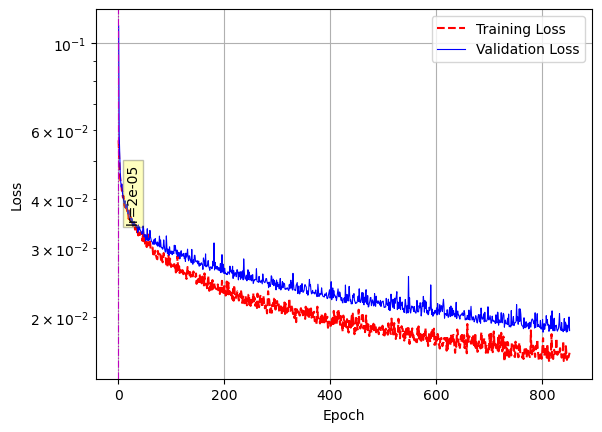

<Figure size 640x480 with 0 Axes>

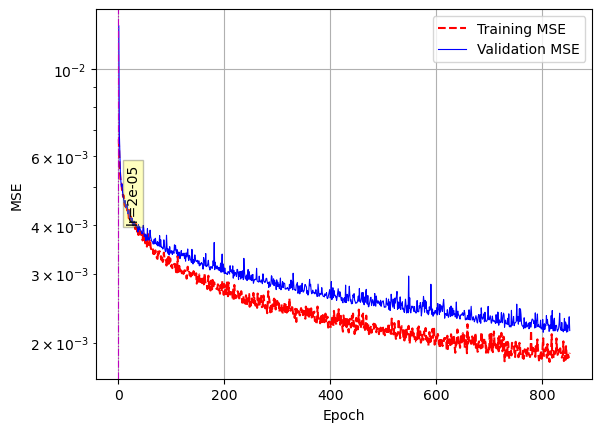

<Figure size 640x480 with 0 Axes>

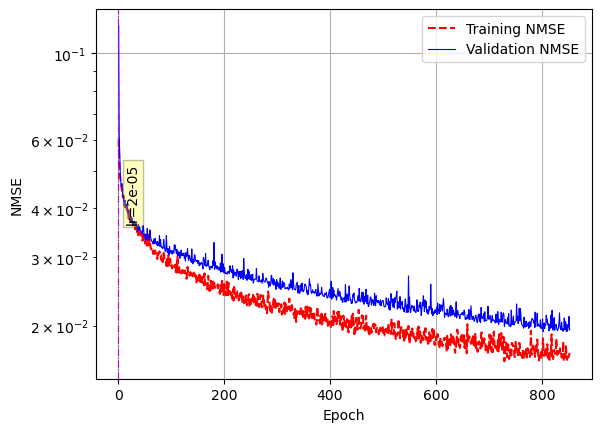

<Figure size 640x480 with 0 Axes>

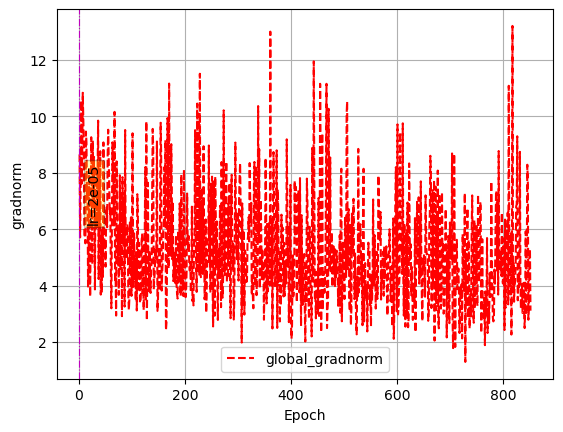

<Figure size 640x480 with 0 Axes>

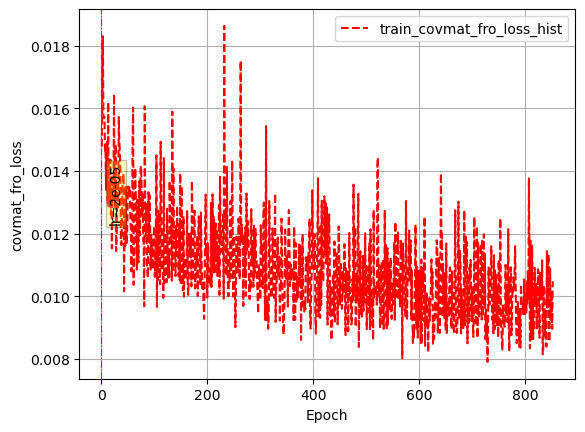



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 11.925
(462, 62, 5000) (462, 10, 5000)
init Wres made : 22.604278087615967 s.
Wres pp dealt with : 36.35051894187927 s.
sparse Wres made : 107.5188844203949 s.
spectral radius found : 206.72993659973145 s.


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
22/22 [==============================] - ETA: 0s - loss: 0.0396 - mse: 0.0049 - NMSE: 0.0448 - covmat_fro_loss: 0.0132 - global_gradnorm: 11.4234 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 0m 45.5s

Epoch 1: val_NMSE im

22/22 [==============================] - ETA: 0s - loss: 0.0357 - mse: 0.0044 - NMSE: 0.0402 - covmat_fro_loss: 0.0129 - global_gradnorm: 11.0048 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 3m 44.2s

Epoch 9: val_NMSE did not improve from 0.03871
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0357 - mse: 0.0044 - NMSE: 0.0402 - covmat_fro_loss: 0.0130 - global_gradnorm: 11.0448 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0347 - val_mse: 0.0043 - val_NMSE: 0.0391 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 10/1000
22/22 [==============================] - ETA: 0s - loss: 0.0351 - mse: 0.0044 - NMSE: 0.0395 - covmat_fro_loss: 0.0128 - global_gradnorm: 9.1930 - rho

Epoch 19/1000
22/22 [==============================] - ETA: 0s - loss: 0.0359 - mse: 0.0045 - NMSE: 0.0404 - covmat_fro_loss: 0.0131 - global_gradnorm: 10.9413 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 7m 27.3s

Epoch 19: val_NMSE did not improve from 0.03814
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0359 - mse: 0.0045 - NMSE: 0.0404 - covmat_fro_loss: 0.0132 - global_gradnorm: 10.9759 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0352 - val_mse: 0.0044 - val_NMSE: 0.0396 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 20/1000
22/22 [==============================] - ETA: 0s - loss: 0.0342 - mse: 0.0043 - NMSE: 0.0386 - covmat_fro_loss: 0.0129 - global_gradnor

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0331 - mse: 0.0041 - NMSE: 0.0372 - covmat_fro_loss: 0.0127 - global_gradnorm: 8.5272 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0328 - val_mse: 0.0041 - val_NMSE: 0.0370 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 29/1000
22/22 [==============================] - ETA: 0s - loss: 0.0333 - mse: 0.0042 - NMSE: 0.0376 - covmat_fro_loss: 0.0128 - global_gradnorm: 10.4543 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 11m 10.9s

Epoch 29: val_NMSE did not improve from 0.03697
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_out

Epoch 38/1000
22/22 [==============================] - ETA: 0s - loss: 0.0332 - mse: 0.0041 - NMSE: 0.0374 - covmat_fro_loss: 0.0128 - global_gradnorm: 10.3974 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 14m 31.9s

Epoch 38: val_NMSE did not improve from 0.03697
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0332 - mse: 0.0041 - NMSE: 0.0374 - covmat_fro_loss: 0.0127 - global_gradnorm: 10.4639 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0339 - val_mse: 0.0042 - val_NMSE: 0.0383 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 39/1000
22/22 [==============================] - ETA: 0s - loss: 0.0321 - mse: 0.0040 - NMSE: 0.0362 - covmat_fro_loss: 0.0126 - global_gradno

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0320 - mse: 0.0040 - NMSE: 0.0360 - covmat_fro_loss: 0.0128 - global_gradnorm: 10.3971 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0340 - val_mse: 0.0042 - val_NMSE: 0.0384 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 48/1000
22/22 [==============================] - ETA: 0s - loss: 0.0310 - mse: 0.0038 - NMSE: 0.0348 - covmat_fro_loss: 0.0125 - global_gradnorm: 8.7322 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 18m 15.4s

Epoch 48: val_NMSE improved from 0.03653 to 0.03648, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/checkpoint-10_outsteps
 - saving loss

Epoch 57/1000
22/22 [==============================] - ETA: 0s - loss: 0.0324 - mse: 0.0040 - NMSE: 0.0364 - covmat_fro_loss: 0.0128 - global_gradnorm: 8.3680 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 21m 36.6s

Epoch 57: val_NMSE did not improve from 0.03598
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0324 - mse: 0.0040 - NMSE: 0.0364 - covmat_fro_loss: 0.0129 - global_gradnorm: 8.4193 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0326 - val_mse: 0.0041 - val_NMSE: 0.0367 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 58/1000
22/22 [==============================] - ETA: 0s - loss: 0.0322 - mse: 0.0040 - NMSE: 0.0362 - covmat_fro_loss: 0.0129 - global_gradnorm

Epoch 67/1000
22/22 [==============================] - ETA: 0s - loss: 0.0314 - mse: 0.0039 - NMSE: 0.0353 - covmat_fro_loss: 0.0126 - global_gradnorm: 10.5455 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 25m 19.8s

Epoch 67: val_NMSE did not improve from 0.03598
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0314 - mse: 0.0039 - NMSE: 0.0353 - covmat_fro_loss: 0.0126 - global_gradnorm: 10.4737 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0322 - val_mse: 0.0040 - val_NMSE: 0.0363 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 68/1000
22/22 [==============================] - ETA: 0s - loss: 0.0305 - mse: 0.0038 - NMSE: 0.0343 - covmat_fro_loss: 0.0125 - global_gradno

Epoch 77/1000
22/22 [==============================] - ETA: 0s - loss: 0.0313 - mse: 0.0039 - NMSE: 0.0352 - covmat_fro_loss: 0.0127 - global_gradnorm: 8.9277 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 29m 3.2s

Epoch 77: val_NMSE did not improve from 0.03580
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0313 - mse: 0.0039 - NMSE: 0.0352 - covmat_fro_loss: 0.0127 - global_gradnorm: 8.8536 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0321 - val_mse: 0.0040 - val_NMSE: 0.0362 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 78/1000
22/22 [==============================] - ETA: 0s - loss: 0.0315 - mse: 0.0039 - NMSE: 0.0355 - covmat_fro_loss: 0.0127 - global_gradnorm:

Epoch 87/1000
22/22 [==============================] - ETA: 0s - loss: 0.0302 - mse: 0.0037 - NMSE: 0.0339 - covmat_fro_loss: 0.0124 - global_gradnorm: 8.9274 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 32m 46.5s

Epoch 87: val_NMSE did not improve from 0.03580
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0302 - mse: 0.0037 - NMSE: 0.0339 - covmat_fro_loss: 0.0124 - global_gradnorm: 8.7888 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0321 - val_mse: 0.0040 - val_NMSE: 0.0362 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 88/1000
22/22 [==============================] - ETA: 0s - loss: 0.0326 - mse: 0.0040 - NMSE: 0.0366 - covmat_fro_loss: 0.0129 - global_gradnorm

Epoch 97/1000
22/22 [==============================] - ETA: 0s - loss: 0.0312 - mse: 0.0039 - NMSE: 0.0351 - covmat_fro_loss: 0.0127 - global_gradnorm: 9.2018 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 36m 28.9s

Epoch 97: val_NMSE did not improve from 0.03580
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0312 - mse: 0.0039 - NMSE: 0.0351 - covmat_fro_loss: 0.0126 - global_gradnorm: 9.0810 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0323 - val_mse: 0.0040 - val_NMSE: 0.0364 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 98/1000
22/22 [==============================] - ETA: 0s - loss: 0.0298 - mse: 0.0037 - NMSE: 0.0335 - covmat_fro_loss: 0.0124 - global_gradnorm

Epoch 107/1000
22/22 [==============================] - ETA: 0s - loss: 0.0293 - mse: 0.0036 - NMSE: 0.0329 - covmat_fro_loss: 0.0124 - global_gradnorm: 8.5669 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 40m 11.7s

Epoch 107: val_NMSE did not improve from 0.03519
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0293 - mse: 0.0036 - NMSE: 0.0329 - covmat_fro_loss: 0.0125 - global_gradnorm: 8.5887 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0321 - val_mse: 0.0040 - val_NMSE: 0.0361 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 108/1000
22/22 [==============================] - ETA: 0s - loss: 0.0290 - mse: 0.0036 - NMSE: 0.0325 - covmat_fro_loss: 0.0123 - global_gradn

Epoch 117/1000
22/22 [==============================] - ETA: 0s - loss: 0.0309 - mse: 0.0038 - NMSE: 0.0347 - covmat_fro_loss: 0.0126 - global_gradnorm: 9.9185 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 43m 55.0s

Epoch 117: val_NMSE did not improve from 0.03515
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0309 - mse: 0.0038 - NMSE: 0.0347 - covmat_fro_loss: 0.0126 - global_gradnorm: 10.0057 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0332 - val_mse: 0.0041 - val_NMSE: 0.0374 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 118/1000
22/22 [==============================] - ETA: 0s - loss: 0.0302 - mse: 0.0037 - NMSE: 0.0339 - covmat_fro_loss: 0.0126 - global_grad

Epoch 127/1000
22/22 [==============================] - ETA: 0s - loss: 0.0289 - mse: 0.0036 - NMSE: 0.0325 - covmat_fro_loss: 0.0123 - global_gradnorm: 8.6051 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 47m 38.8s

Epoch 127: val_NMSE did not improve from 0.03515
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0289 - mse: 0.0036 - NMSE: 0.0325 - covmat_fro_loss: 0.0124 - global_gradnorm: 8.5912 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0335 - val_mse: 0.0042 - val_NMSE: 0.0378 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 128/1000
22/22 [==============================] - ETA: 0s - loss: 0.0311 - mse: 0.0039 - NMSE: 0.0349 - covmat_fro_loss: 0.0127 - global_gradn

Epoch 137/1000
22/22 [==============================] - ETA: 0s - loss: 0.0295 - mse: 0.0037 - NMSE: 0.0331 - covmat_fro_loss: 0.0125 - global_gradnorm: 9.5669 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 51m 22.9s

Epoch 137: val_NMSE did not improve from 0.03515
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0295 - mse: 0.0037 - NMSE: 0.0331 - covmat_fro_loss: 0.0125 - global_gradnorm: 9.6302 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0325 - val_mse: 0.0040 - val_NMSE: 0.0366 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 138/1000
22/22 [==============================] - ETA: 0s - loss: 0.0294 - mse: 0.0036 - NMSE: 0.0330 - covmat_fro_loss: 0.0124 - global_gradn

Epoch 147/1000
22/22 [==============================] - ETA: 0s - loss: 0.0290 - mse: 0.0036 - NMSE: 0.0326 - covmat_fro_loss: 0.0124 - global_gradnorm: 8.5722 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 55m 6.2s

Epoch 147: val_NMSE did not improve from 0.03515
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0290 - mse: 0.0036 - NMSE: 0.0326 - covmat_fro_loss: 0.0124 - global_gradnorm: 8.4446 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0315 - val_mse: 0.0039 - val_NMSE: 0.0354 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 148/1000
22/22 [==============================] - ETA: 0s - loss: 0.0278 - mse: 0.0035 - NMSE: 0.0313 - covmat_fro_loss: 0.0121 - global_gradno

Epoch 157/1000
22/22 [==============================] - ETA: 0s - loss: 0.0288 - mse: 0.0036 - NMSE: 0.0323 - covmat_fro_loss: 0.0124 - global_gradnorm: 9.0938 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 58m 50.0s

Epoch 157: val_NMSE did not improve from 0.03461
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0288 - mse: 0.0036 - NMSE: 0.0323 - covmat_fro_loss: 0.0125 - global_gradnorm: 9.0152 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0334 - val_mse: 0.0042 - val_NMSE: 0.0377 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 158/1000
22/22 [==============================] - ETA: 0s - loss: 0.0286 - mse: 0.0035 - NMSE: 0.0320 - covmat_fro_loss: 0.0123 - global_gradn

Epoch 167/1000
22/22 [==============================] - ETA: 0s - loss: 0.0289 - mse: 0.0036 - NMSE: 0.0325 - covmat_fro_loss: 0.0123 - global_gradnorm: 9.2228 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 2m 34.2s

Epoch 167: val_NMSE did not improve from 0.03461
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0289 - mse: 0.0036 - NMSE: 0.0325 - covmat_fro_loss: 0.0124 - global_gradnorm: 9.0466 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0311 - val_mse: 0.0039 - val_NMSE: 0.0351 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 168/1000
22/22 [==============================] - ETA: 0s - loss: 0.0280 - mse: 0.0035 - NMSE: 0.0314 - covmat_fro_loss: 0.0122 - global_gradno

Epoch 177/1000
22/22 [==============================] - ETA: 0s - loss: 0.0287 - mse: 0.0036 - NMSE: 0.0322 - covmat_fro_loss: 0.0123 - global_gradnorm: 9.0251 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 6m 17.4s

Epoch 177: val_NMSE did not improve from 0.03461
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0287 - mse: 0.0036 - NMSE: 0.0322 - covmat_fro_loss: 0.0122 - global_gradnorm: 8.9985 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0323 - val_mse: 0.0040 - val_NMSE: 0.0364 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 178/1000
22/22 [==============================] - ETA: 0s - loss: 0.0285 - mse: 0.0035 - NMSE: 0.0320 - covmat_fro_loss: 0.0123 - global_gradno

Epoch 187/1000
22/22 [==============================] - ETA: 0s - loss: 0.0298 - mse: 0.0037 - NMSE: 0.0335 - covmat_fro_loss: 0.0126 - global_gradnorm: 9.0935 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 11m 8.2s

Epoch 187: val_NMSE did not improve from 0.03461
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0298 - mse: 0.0037 - NMSE: 0.0335 - covmat_fro_loss: 0.0126 - global_gradnorm: 9.0720 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0311 - val_mse: 0.0039 - val_NMSE: 0.0350 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 188/1000
22/22 [==============================] - ETA: 0s - loss: 0.0274 - mse: 0.0034 - NMSE: 0.0307 - covmat_fro_loss: 0.0122 - global_gradno

Epoch 197/1000
22/22 [==============================] - ETA: 0s - loss: 0.0290 - mse: 0.0036 - NMSE: 0.0326 - covmat_fro_loss: 0.0123 - global_gradnorm: 7.7551 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 15m 37.5s

Epoch 197: val_NMSE improved from 0.03461 to 0.03445, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 24s 1s/step - loss: 0.0290 - mse: 0.0036 - NMSE: 0.0326 - covmat_fro_loss: 0.0123 - global_gradnorm: 7.7893 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0306 - val_mse: 0.0038 - val_NMSE: 0.0345 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 198/100

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0278 - mse: 0.0034 - NMSE: 0.0312 - covmat_fro_loss: 0.0123 - global_gradnorm: 9.2819 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0322 - val_mse: 0.0040 - val_NMSE: 0.0363 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 207/1000
22/22 [==============================] - ETA: 0s - loss: 0.0278 - mse: 0.0034 - NMSE: 0.0312 - covmat_fro_loss: 0.0122 - global_gradnorm: 9.9638 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000  - tot_time: 1h 19m 22.9s

Epoch 207: val_NMSE did not improve from 0.03444
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_o

Epoch 216/1000
22/22 [==============================] - ETA: 0s - loss: 0.0285 - mse: 0.0035 - NMSE: 0.0320 - covmat_fro_loss: 0.0124 - global_gradnorm: 9.0595 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 22m 43.8s

Epoch 216: val_NMSE did not improve from 0.03441
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0285 - mse: 0.0035 - NMSE: 0.0320 - covmat_fro_loss: 0.0124 - global_gradnorm: 8.9896 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0309 - val_mse: 0.0038 - val_NMSE: 0.0347 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 217/1000
22/22 [==============================] - ETA: 0s - loss: 0.0272 - mse: 0.0034 - NMSE: 0.0306 - covmat_fro_loss: 0.0121 - global_gradn

Epoch 226/1000
22/22 [==============================] - ETA: 0s - loss: 0.0280 - mse: 0.0035 - NMSE: 0.0314 - covmat_fro_loss: 0.0123 - global_gradnorm: 8.7801 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 26m 27.0s

Epoch 226: val_NMSE did not improve from 0.03441
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0280 - mse: 0.0035 - NMSE: 0.0314 - covmat_fro_loss: 0.0123 - global_gradnorm: 8.9168 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0311 - val_mse: 0.0039 - val_NMSE: 0.0350 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 227/1000
22/22 [==============================] - ETA: 0s - loss: 0.0285 - mse: 0.0035 - NMSE: 0.0319 - covmat_fro_loss: 0.0124 - global_gradn

Epoch 236/1000
22/22 [==============================] - ETA: 0s - loss: 0.0283 - mse: 0.0035 - NMSE: 0.0317 - covmat_fro_loss: 0.0123 - global_gradnorm: 7.2471 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 30m 10.3s

Epoch 236: val_NMSE did not improve from 0.03440
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0283 - mse: 0.0035 - NMSE: 0.0317 - covmat_fro_loss: 0.0123 - global_gradnorm: 7.2789 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0310 - val_mse: 0.0039 - val_NMSE: 0.0349 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 237/1000
22/22 [==============================] - ETA: 0s - loss: 0.0274 - mse: 0.0034 - NMSE: 0.0307 - covmat_fro_loss: 0.0121 - global_gradn

Epoch 246/1000
22/22 [==============================] - ETA: 0s - loss: 0.0266 - mse: 0.0033 - NMSE: 0.0298 - covmat_fro_loss: 0.0120 - global_gradnorm: 8.0941 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 33m 53.6s

Epoch 246: val_NMSE did not improve from 0.03422
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0266 - mse: 0.0033 - NMSE: 0.0298 - covmat_fro_loss: 0.0121 - global_gradnorm: 8.2606 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0312 - val_mse: 0.0039 - val_NMSE: 0.0352 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 247/1000
22/22 [==============================] - ETA: 0s - loss: 0.0281 - mse: 0.0035 - NMSE: 0.0315 - covmat_fro_loss: 0.0122 - global_gradn

Epoch 256/1000
22/22 [==============================] - ETA: 0s - loss: 0.0271 - mse: 0.0034 - NMSE: 0.0304 - covmat_fro_loss: 0.0122 - global_gradnorm: 9.2255 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 37m 37.0s

Epoch 256: val_NMSE did not improve from 0.03422
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0271 - mse: 0.0034 - NMSE: 0.0304 - covmat_fro_loss: 0.0121 - global_gradnorm: 9.2339 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0306 - val_mse: 0.0038 - val_NMSE: 0.0344 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 257/1000
22/22 [==============================] - ETA: 0s - loss: 0.0270 - mse: 0.0033 - NMSE: 0.0302 - covmat_fro_loss: 0.0121 - global_gradn

Epoch 266/1000
22/22 [==============================] - ETA: 0s - loss: 0.0265 - mse: 0.0033 - NMSE: 0.0297 - covmat_fro_loss: 0.0120 - global_gradnorm: 9.6575 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 41m 20.6s

Epoch 266: val_NMSE did not improve from 0.03421
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 23s 1s/step - loss: 0.0265 - mse: 0.0033 - NMSE: 0.0297 - covmat_fro_loss: 0.0120 - global_gradnorm: 9.7538 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0305 - val_mse: 0.0038 - val_NMSE: 0.0344 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 267/1000
22/22 [==============================] - ETA: 0s - loss: 0.0275 - mse: 0.0034 - NMSE: 0.0309 - covmat_fro_loss: 0.0122 - global_gradn

Epoch 276/1000
22/22 [==============================] - ETA: 0s - loss: 0.0271 - mse: 0.0034 - NMSE: 0.0304 - covmat_fro_loss: 0.0120 - global_gradnorm: 9.0906 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 45m 4.8s

Epoch 276: val_NMSE did not improve from 0.03394
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0271 - mse: 0.0034 - NMSE: 0.0304 - covmat_fro_loss: 0.0121 - global_gradnorm: 8.9647 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0307 - val_mse: 0.0038 - val_NMSE: 0.0346 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 277/1000
22/22 [==============================] - ETA: 0s - loss: 0.0263 - mse: 0.0033 - NMSE: 0.0295 - covmat_fro_loss: 0.0119 - global_gradno

Epoch 286/1000
22/22 [==============================] - ETA: 0s - loss: 0.0260 - mse: 0.0032 - NMSE: 0.0292 - covmat_fro_loss: 0.0119 - global_gradnorm: 6.7888 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 48m 48.1s

Epoch 286: val_NMSE did not improve from 0.03394
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0260 - mse: 0.0032 - NMSE: 0.0292 - covmat_fro_loss: 0.0119 - global_gradnorm: 6.7729 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0310 - val_mse: 0.0039 - val_NMSE: 0.0349 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 287/1000
22/22 [==============================] - ETA: 0s - loss: 0.0264 - mse: 0.0033 - NMSE: 0.0296 - covmat_fro_loss: 0.0120 - global_gradn

Epoch 296/1000
22/22 [==============================] - ETA: 0s - loss: 0.0265 - mse: 0.0033 - NMSE: 0.0297 - covmat_fro_loss: 0.0120 - global_gradnorm: 8.5410 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 52m 32.3s

Epoch 296: val_NMSE did not improve from 0.03394
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0265 - mse: 0.0033 - NMSE: 0.0297 - covmat_fro_loss: 0.0120 - global_gradnorm: 8.3716 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0323 - val_mse: 0.0040 - val_NMSE: 0.0364 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 297/1000
22/22 [==============================] - ETA: 0s - loss: 0.0266 - mse: 0.0033 - NMSE: 0.0298 - covmat_fro_loss: 0.0121 - global_gradn

Epoch 306/1000
22/22 [==============================] - ETA: 0s - loss: 0.0263 - mse: 0.0033 - NMSE: 0.0295 - covmat_fro_loss: 0.0119 - global_gradnorm: 7.4076 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 56m 15.3s

Epoch 306: val_NMSE improved from 0.03394 to 0.03373, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0263 - mse: 0.0033 - NMSE: 0.0295 - covmat_fro_loss: 0.0120 - global_gradnorm: 7.4244 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0300 - val_mse: 0.0037 - val_NMSE: 0.0337 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 307/100

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0271 - mse: 0.0034 - NMSE: 0.0303 - covmat_fro_loss: 0.0122 - global_gradnorm: 8.7847 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0325 - val_mse: 0.0040 - val_NMSE: 0.0366 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 316/1000
22/22 [==============================] - ETA: 0s - loss: 0.0271 - mse: 0.0034 - NMSE: 0.0303 - covmat_fro_loss: 0.0121 - global_gradnorm: 9.2357 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 59m 58.7s

Epoch 316: val_NMSE did not improve from 0.03357
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_ou

Epoch 325/1000
22/22 [==============================] - ETA: 0s - loss: 0.0274 - mse: 0.0034 - NMSE: 0.0307 - covmat_fro_loss: 0.0122 - global_gradnorm: 7.8877 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 2h 3m 19.6s

Epoch 325: val_NMSE did not improve from 0.03357
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0274 - mse: 0.0034 - NMSE: 0.0307 - covmat_fro_loss: 0.0122 - global_gradnorm: 8.0632 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0312 - val_mse: 0.0039 - val_NMSE: 0.0351 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 326/1000
22/22 [==============================] - ETA: 0s - loss: 0.0256 - mse: 0.0032 - NMSE: 0.0287 - covmat_fro_loss: 0.0119 - global_gradno

Epoch 335/1000
22/22 [==============================] - ETA: 0s - loss: 0.0265 - mse: 0.0033 - NMSE: 0.0298 - covmat_fro_loss: 0.0120 - global_gradnorm: 9.2405 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 2h 7m 2.9s

Epoch 335: val_NMSE did not improve from 0.03357
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0265 - mse: 0.0033 - NMSE: 0.0298 - covmat_fro_loss: 0.0120 - global_gradnorm: 9.0981 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0328 - val_mse: 0.0041 - val_NMSE: 0.0370 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 336/1000
22/22 [==============================] - ETA: 0s - loss: 0.0269 - mse: 0.0033 - NMSE: 0.0302 - covmat_fro_loss: 0.0121 - global_gradnor

Epoch 345/1000
22/22 [==============================] - ETA: 0s - loss: 0.0264 - mse: 0.0033 - NMSE: 0.0296 - covmat_fro_loss: 0.0120 - global_gradnorm: 6.3806 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 2h 10m 46.3s

Epoch 345: val_NMSE did not improve from 0.03357
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0264 - mse: 0.0033 - NMSE: 0.0296 - covmat_fro_loss: 0.0121 - global_gradnorm: 6.4115 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0316 - val_mse: 0.0039 - val_NMSE: 0.0356 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 346/1000
22/22 [==============================] - ETA: 0s - loss: 0.0254 - mse: 0.0031 - NMSE: 0.0285 - covmat_fro_loss: 0.0118 - global_gradn

Epoch 355/1000
22/22 [==============================] - ETA: 0s - loss: 0.0258 - mse: 0.0032 - NMSE: 0.0289 - covmat_fro_loss: 0.0119 - global_gradnorm: 8.4629 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 2h 14m 29.7s

Epoch 355: val_NMSE did not improve from 0.03357
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-10_outsteps
22/22 [==============================] - 22s 1s/step - loss: 0.0258 - mse: 0.0032 - NMSE: 0.0289 - covmat_fro_loss: 0.0119 - global_gradnorm: 8.2792 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0299 - val_mse: 0.0037 - val_NMSE: 0.0336 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 356/1000
22/22 [==============================] - ETA: 0s - loss: 0.0252 - mse: 0.0031 - NMSE: 0.0283 - covmat_fro_loss: 0.0117 - global_gradn

<Figure size 640x480 with 0 Axes>

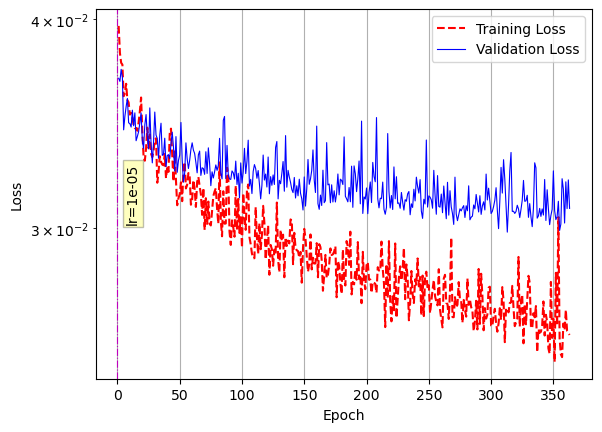

<Figure size 640x480 with 0 Axes>

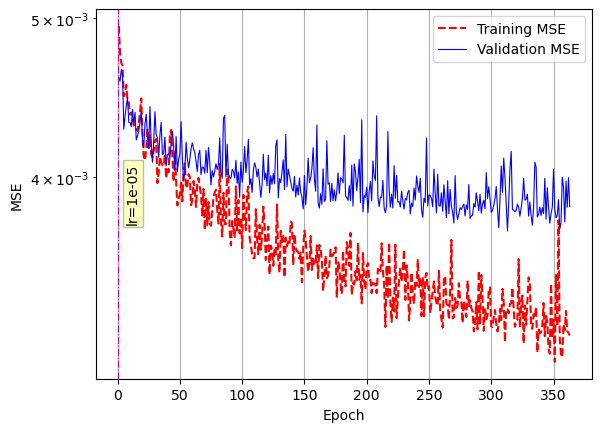

<Figure size 640x480 with 0 Axes>

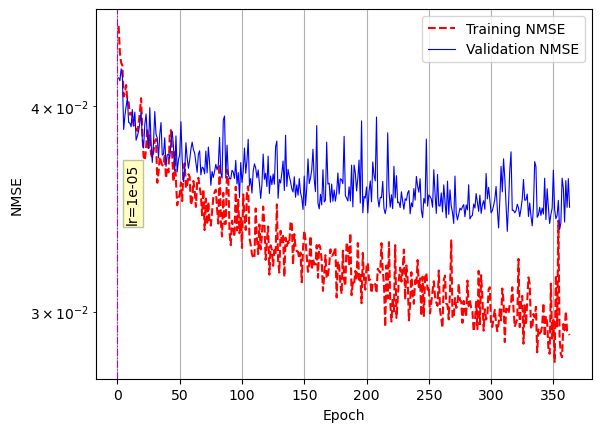

<Figure size 640x480 with 0 Axes>

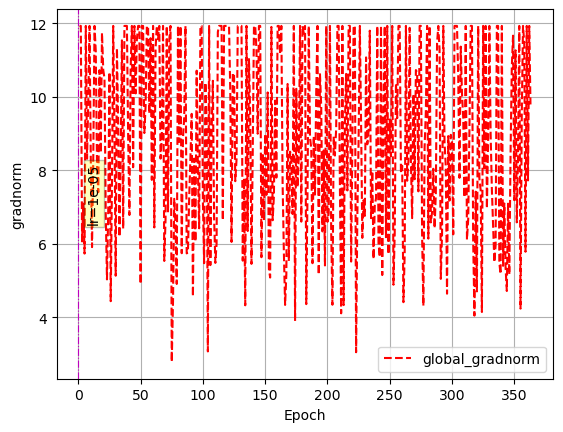

<Figure size 640x480 with 0 Axes>

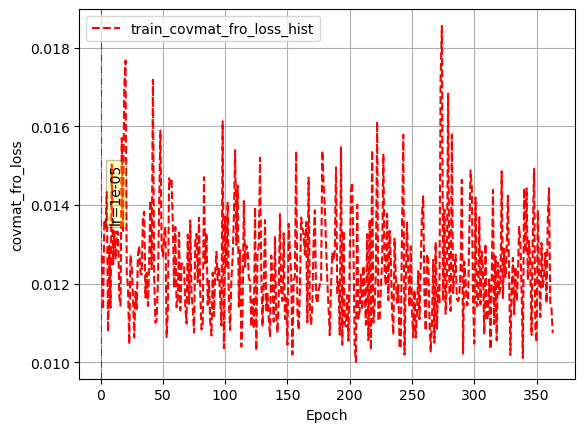



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 30 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 10.8
(362, 62, 5000) (362, 30, 5000)
init Wres made : 22.654525995254517 s.
Wres pp dealt with : 36.695611238479614 s.
sparse Wres made : 74.7307481765747 s.
spectral radius found : 226.3661322593689 s.


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 2e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
18/18 [==============================] - ETA: 0s - loss: 0.0915 - mse: 0.0149 - NMSE: 0.1354 - covmat_fro_loss: 0.0162 - global_gradnorm: 10.7323 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 1m 36.3s

Epoch 1: val_NMSE impro

Epoch 9/1000
18/18 [==============================] - ETA: 0s - loss: 0.0827 - mse: 0.0135 - NMSE: 0.1219 - covmat_fro_loss: 0.0156 - global_gradnorm: 10.3152 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 5m 49.7s

Epoch 9: val_NMSE did not improve from 0.12124
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 32s 2s/step - loss: 0.0827 - mse: 0.0135 - NMSE: 0.1219 - covmat_fro_loss: 0.0156 - global_gradnorm: 10.3407 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0882 - val_mse: 0.0144 - val_NMSE: 0.1305 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 10/1000
18/18 [==============================] - ETA: 0s - loss: 0.0850 - mse: 0.0138 - NMSE: 0.1251 - covmat_fro_loss: 0.0159 - global_gradnorm:

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 32s 2s/step - loss: 0.0823 - mse: 0.0134 - NMSE: 0.1211 - covmat_fro_loss: 0.0157 - global_gradnorm: 10.1506 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0851 - val_mse: 0.0139 - val_NMSE: 0.1255 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 19/1000
18/18 [==============================] - ETA: 0s - loss: 0.0798 - mse: 0.0130 - NMSE: 0.1174 - covmat_fro_loss: 0.0155 - global_gradnorm: 10.3790 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 11m 6.1s

Epoch 19: val_NMSE did not improve from 0.11700
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-30_out

Epoch 28/1000
18/18 [==============================] - ETA: 0s - loss: 0.0812 - mse: 0.0132 - NMSE: 0.1195 - covmat_fro_loss: 0.0157 - global_gradnorm: 10.7211 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 15m 50.8s

Epoch 28: val_NMSE did not improve from 0.11660
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 32s 2s/step - loss: 0.0812 - mse: 0.0132 - NMSE: 0.1195 - covmat_fro_loss: 0.0156 - global_gradnorm: 10.7165 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0822 - val_mse: 0.0134 - val_NMSE: 0.1210 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 29/1000
18/18 [==============================] - ETA: 0s - loss: 0.0823 - mse: 0.0134 - NMSE: 0.1213 - covmat_fro_loss: 0.0158 - global_gradno

Epoch 38/1000
18/18 [==============================] - ETA: 0s - loss: 0.0796 - mse: 0.0129 - NMSE: 0.1168 - covmat_fro_loss: 0.0157 - global_gradnorm: 10.2007 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 21m 7.1s

Epoch 38: val_NMSE did not improve from 0.11561
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 32s 2s/step - loss: 0.0796 - mse: 0.0129 - NMSE: 0.1168 - covmat_fro_loss: 0.0157 - global_gradnorm: 10.2323 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0800 - val_mse: 0.0130 - val_NMSE: 0.1173 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 39/1000
18/18 [==============================] - ETA: 0s - loss: 0.0803 - mse: 0.0130 - NMSE: 0.1180 - covmat_fro_loss: 0.0157 - global_gradnor

Epoch 48/1000
18/18 [==============================] - ETA: 0s - loss: 0.0783 - mse: 0.0127 - NMSE: 0.1148 - covmat_fro_loss: 0.0156 - global_gradnorm: 10.5063 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 26m 23.4s

Epoch 48: val_NMSE did not improve from 0.11458
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 32s 2s/step - loss: 0.0783 - mse: 0.0127 - NMSE: 0.1148 - covmat_fro_loss: 0.0154 - global_gradnorm: 10.5218 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0803 - val_mse: 0.0130 - val_NMSE: 0.1178 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 49/1000
18/18 [==============================] - ETA: 0s - loss: 0.0808 - mse: 0.0131 - NMSE: 0.1185 - covmat_fro_loss: 0.0159 - global_gradno

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 32s 2s/step - loss: 0.0800 - mse: 0.0130 - NMSE: 0.1174 - covmat_fro_loss: 0.0158 - global_gradnorm: 10.5723 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0779 - val_mse: 0.0126 - val_NMSE: 0.1138 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 58/1000
18/18 [==============================] - ETA: 0s - loss: 0.0794 - mse: 0.0129 - NMSE: 0.1165 - covmat_fro_loss: 0.0157 - global_gradnorm: 10.5288 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 31m 39.6s

Epoch 58: val_NMSE did not improve from 0.11375
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-30_ou

Epoch 67/1000
18/18 [==============================] - ETA: 0s - loss: 0.0762 - mse: 0.0123 - NMSE: 0.1118 - covmat_fro_loss: 0.0155 - global_gradnorm: 10.0720 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 36m 24.2s

Epoch 67: val_NMSE did not improve from 0.11240
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 32s 2s/step - loss: 0.0762 - mse: 0.0123 - NMSE: 0.1118 - covmat_fro_loss: 0.0155 - global_gradnorm: 10.1103 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0820 - val_mse: 0.0133 - val_NMSE: 0.1203 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 68/1000
18/18 [==============================] - ETA: 0s - loss: 0.0783 - mse: 0.0127 - NMSE: 0.1148 - covmat_fro_loss: 0.0157 - global_gradno

Epoch 77/1000
18/18 [==============================] - ETA: 0s - loss: 0.0763 - mse: 0.0123 - NMSE: 0.1118 - covmat_fro_loss: 0.0155 - global_gradnorm: 10.3811 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 41m 40.3s

Epoch 77: val_NMSE did not improve from 0.11240
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 32s 2s/step - loss: 0.0763 - mse: 0.0123 - NMSE: 0.1118 - covmat_fro_loss: 0.0154 - global_gradnorm: 10.4031 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0777 - val_mse: 0.0125 - val_NMSE: 0.1135 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 78/1000
18/18 [==============================] - ETA: 0s - loss: 0.0789 - mse: 0.0128 - NMSE: 0.1158 - covmat_fro_loss: 0.0158 - global_gradno

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 32s 2s/step - loss: 0.0770 - mse: 0.0125 - NMSE: 0.1128 - covmat_fro_loss: 0.0157 - global_gradnorm: 10.6732 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0763 - val_mse: 0.0123 - val_NMSE: 0.1111 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 87/1000
18/18 [==============================] - ETA: 0s - loss: 0.0761 - mse: 0.0123 - NMSE: 0.1115 - covmat_fro_loss: 0.0155 - global_gradnorm: 9.7199 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 46m 56.8s

Epoch 87: val_NMSE did not improve from 0.11114
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-30_out

Epoch 96/1000
18/18 [==============================] - ETA: 0s - loss: 0.0742 - mse: 0.0120 - NMSE: 0.1089 - covmat_fro_loss: 0.0153 - global_gradnorm: 10.1713 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 51m 41.3s

Epoch 96: val_NMSE did not improve from 0.11114
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 32s 2s/step - loss: 0.0742 - mse: 0.0120 - NMSE: 0.1089 - covmat_fro_loss: 0.0155 - global_gradnorm: 10.0948 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0766 - val_mse: 0.0123 - val_NMSE: 0.1116 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 97/1000
18/18 [==============================] - ETA: 0s - loss: 0.0758 - mse: 0.0123 - NMSE: 0.1113 - covmat_fro_loss: 0.0155 - global_gradno

Epoch 106/1000
18/18 [==============================] - ETA: 0s - loss: 0.0763 - mse: 0.0124 - NMSE: 0.1119 - covmat_fro_loss: 0.0156 - global_gradnorm: 10.7625 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 56m 57.4s

Epoch 106: val_NMSE did not improve from 0.11114
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 32s 2s/step - loss: 0.0763 - mse: 0.0124 - NMSE: 0.1119 - covmat_fro_loss: 0.0155 - global_gradnorm: 10.7644 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0802 - val_mse: 0.0129 - val_NMSE: 0.1172 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 107/1000
18/18 [==============================] - ETA: 0s - loss: 0.0761 - mse: 0.0123 - NMSE: 0.1116 - covmat_fro_loss: 0.0155 - global_gra

Epoch 116/1000
18/18 [==============================] - ETA: 0s - loss: 0.0754 - mse: 0.0122 - NMSE: 0.1104 - covmat_fro_loss: 0.0155 - global_gradnorm: 9.7396 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 2m 13.5s

Epoch 116: val_NMSE did not improve from 0.11114
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 32s 2s/step - loss: 0.0754 - mse: 0.0122 - NMSE: 0.1104 - covmat_fro_loss: 0.0156 - global_gradnorm: 9.6936 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0795 - val_mse: 0.0128 - val_NMSE: 0.1162 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 117/1000
18/18 [==============================] - ETA: 0s - loss: 0.0757 - mse: 0.0123 - NMSE: 0.1110 - covmat_fro_loss: 0.0157 - global_gradno

Epoch 126/1000
18/18 [==============================] - ETA: 0s - loss: 0.0764 - mse: 0.0124 - NMSE: 0.1120 - covmat_fro_loss: 0.0157 - global_gradnorm: 10.8000 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 7m 29.7s

Epoch 126: val_NMSE did not improve from 0.11114
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 32s 2s/step - loss: 0.0764 - mse: 0.0124 - NMSE: 0.1120 - covmat_fro_loss: 0.0156 - global_gradnorm: 10.8000 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0779 - val_mse: 0.0126 - val_NMSE: 0.1137 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 127/1000
18/18 [==============================] - ETA: 0s - loss: 0.0743 - mse: 0.0120 - NMSE: 0.1088 - covmat_fro_loss: 0.0154 - global_grad

Epoch 136/1000
18/18 [==============================] - ETA: 0s - loss: 0.0757 - mse: 0.0123 - NMSE: 0.1111 - covmat_fro_loss: 0.0156 - global_gradnorm: 10.7571 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000Restoring model weights from the end of the best epoch: 86.
 - tot_time: 1h 12m 46.0s

Epoch 136: val_NMSE did not improve from 0.11099
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-30_outsteps
18/18 [==============================] - 32s 2s/step - loss: 0.0757 - mse: 0.0123 - NMSE: 0.1111 - covmat_fro_loss: 0.0156 - global_gradnorm: 10.7594 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0775 - val_mse: 0.0125 - val_NMSE: 0.1128 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 136: early stopping


<Figure size 640x480 with 0 Axes>

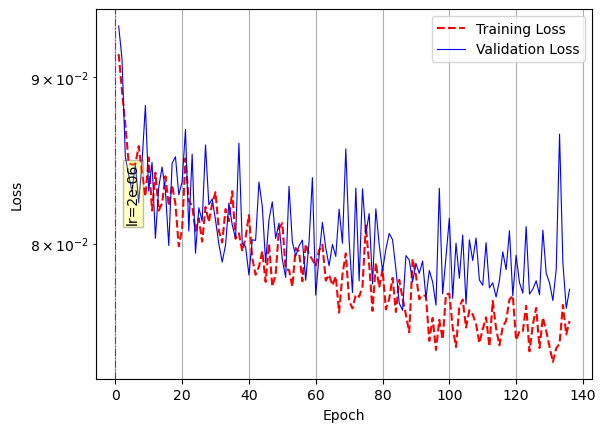

<Figure size 640x480 with 0 Axes>

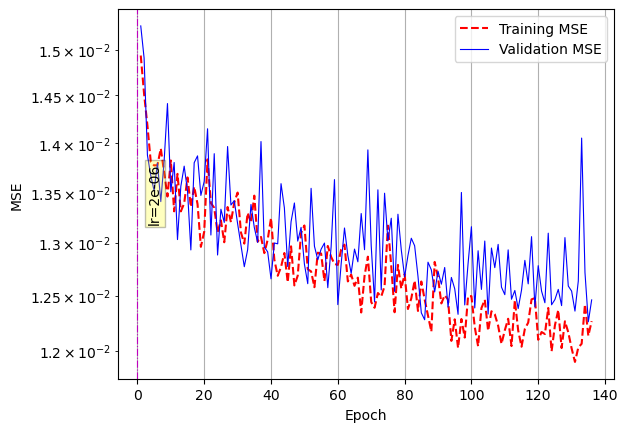

<Figure size 640x480 with 0 Axes>

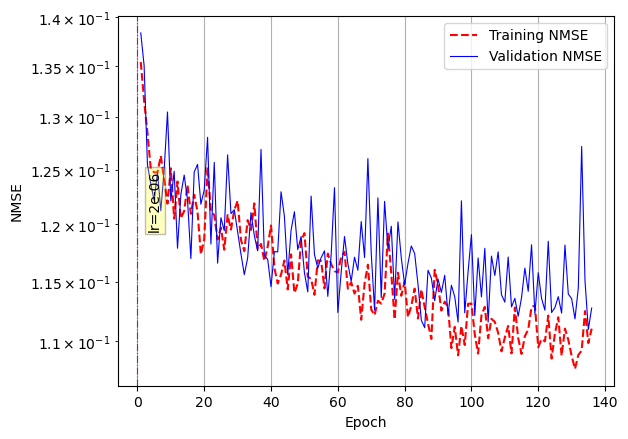

<Figure size 640x480 with 0 Axes>

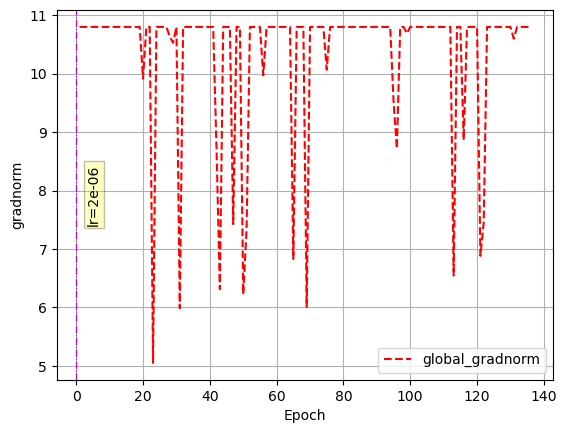

<Figure size 640x480 with 0 Axes>

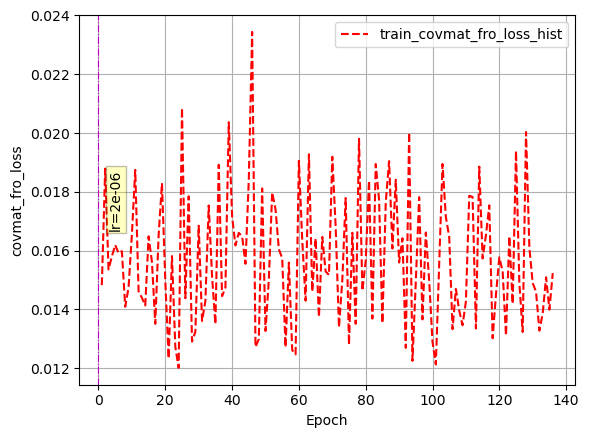



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 50 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 9.675
(297, 62, 5000) (297, 50, 5000)
init Wres made : 22.307723999023438 s.
Wres pp dealt with : 35.994601249694824 s.
sparse Wres made : 73.87528586387634 s.
spectral radius found : 174.45554995536804 s.


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
14/14 [==============================] - ETA: 0s - loss: 0.1121 - mse: 0.0237 - NMSE: 0.2146 - covmat_fro_loss: 0.0158 - global_gradnorm: 9.5439 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 2m 21.9s

Epoch 1: val_NMSE imp

14/14 [==============================] - ETA: 0s - loss: 0.1085 - mse: 0.0229 - NMSE: 0.2075 - covmat_fro_loss: 0.0158 - global_gradnorm: 9.4203 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 7m 8.1s

Epoch 9: val_NMSE did not improve from 0.18847
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 36s 3s/step - loss: 0.1085 - mse: 0.0229 - NMSE: 0.2075 - covmat_fro_loss: 0.0158 - global_gradnorm: 9.4373 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1032 - val_mse: 0.0217 - val_NMSE: 0.1971 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 10/1000
14/14 [==============================] - ETA: 0s - loss: 0.1063 - mse: 0.0224 - NMSE: 0.2029 - covmat_fro_loss: 0.0156 - global_gradnorm: 9.3210 - rho_re

Epoch 19/1000
14/14 [==============================] - ETA: 0s - loss: 0.1086 - mse: 0.0229 - NMSE: 0.2072 - covmat_fro_loss: 0.0158 - global_gradnorm: 9.4783 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 13m 5.5s

Epoch 19: val_NMSE did not improve from 0.18847
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 36s 3s/step - loss: 0.1086 - mse: 0.0229 - NMSE: 0.2072 - covmat_fro_loss: 0.0159 - global_gradnorm: 9.4914 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1019 - val_mse: 0.0214 - val_NMSE: 0.1944 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 20/1000
14/14 [==============================] - ETA: 0s - loss: 0.1061 - mse: 0.0224 - NMSE: 0.2027 - covmat_fro_loss: 0.0157 - global_gradnorm:

Epoch 29/1000
14/14 [==============================] - ETA: 0s - loss: 0.1078 - mse: 0.0227 - NMSE: 0.2058 - covmat_fro_loss: 0.0158 - global_gradnorm: 9.0865 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 19m 3.0s

Epoch 29: val_NMSE did not improve from 0.18535
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 36s 3s/step - loss: 0.1078 - mse: 0.0227 - NMSE: 0.2058 - covmat_fro_loss: 0.0158 - global_gradnorm: 9.1258 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0997 - val_mse: 0.0208 - val_NMSE: 0.1887 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 30/1000
14/14 [==============================] - ETA: 0s - loss: 0.1064 - mse: 0.0225 - NMSE: 0.2033 - covmat_fro_loss: 0.0158 - global_gradnorm:

Epoch 39/1000
14/14 [==============================] - ETA: 0s - loss: 0.1079 - mse: 0.0227 - NMSE: 0.2058 - covmat_fro_loss: 0.0158 - global_gradnorm: 9.6518 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 25m 0.2s

Epoch 39: val_NMSE did not improve from 0.18535
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 36s 3s/step - loss: 0.1079 - mse: 0.0227 - NMSE: 0.2058 - covmat_fro_loss: 0.0156 - global_gradnorm: 9.6533 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1016 - val_mse: 0.0213 - val_NMSE: 0.1928 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 40/1000
14/14 [==============================] - ETA: 0s - loss: 0.1063 - mse: 0.0224 - NMSE: 0.2031 - covmat_fro_loss: 0.0158 - global_gradnorm:

Epoch 49/1000
14/14 [==============================] - ETA: 0s - loss: 0.1060 - mse: 0.0223 - NMSE: 0.2018 - covmat_fro_loss: 0.0158 - global_gradnorm: 9.2629 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 30m 57.7s

Epoch 49: val_NMSE did not improve from 0.18412
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 36s 3s/step - loss: 0.1060 - mse: 0.0223 - NMSE: 0.2018 - covmat_fro_loss: 0.0157 - global_gradnorm: 9.2904 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0994 - val_mse: 0.0208 - val_NMSE: 0.1881 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 50/1000
14/14 [==============================] - ETA: 0s - loss: 0.1087 - mse: 0.0229 - NMSE: 0.2072 - covmat_fro_loss: 0.0160 - global_gradnorm

Epoch 59/1000
14/14 [==============================] - ETA: 0s - loss: 0.1071 - mse: 0.0225 - NMSE: 0.2041 - covmat_fro_loss: 0.0159 - global_gradnorm: 9.6750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 36m 55.9s

Epoch 59: val_NMSE did not improve from 0.18301
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 36s 3s/step - loss: 0.1071 - mse: 0.0225 - NMSE: 0.2041 - covmat_fro_loss: 0.0159 - global_gradnorm: 9.6750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1032 - val_mse: 0.0216 - val_NMSE: 0.1961 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 60/1000
14/14 [==============================] - ETA: 0s - loss: 0.1077 - mse: 0.0226 - NMSE: 0.2049 - covmat_fro_loss: 0.0159 - global_gradnorm

Epoch 69/1000
14/14 [==============================] - ETA: 0s - loss: 0.1072 - mse: 0.0225 - NMSE: 0.2041 - covmat_fro_loss: 0.0159 - global_gradnorm: 9.5525 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 42m 53.4s

Epoch 69: val_NMSE did not improve from 0.18301
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 36s 3s/step - loss: 0.1072 - mse: 0.0225 - NMSE: 0.2041 - covmat_fro_loss: 0.0158 - global_gradnorm: 9.5607 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1016 - val_mse: 0.0212 - val_NMSE: 0.1926 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 70/1000
14/14 [==============================] - ETA: 0s - loss: 0.1042 - mse: 0.0219 - NMSE: 0.1981 - covmat_fro_loss: 0.0158 - global_gradnorm

Epoch 79/1000
14/14 [==============================] - ETA: 0s - loss: 0.1055 - mse: 0.0222 - NMSE: 0.2009 - covmat_fro_loss: 0.0159 - global_gradnorm: 9.5496 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 48m 50.9s

Epoch 79: val_NMSE improved from 0.18134 to 0.18046, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/checkpoint-50_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 36s 3s/step - loss: 0.1055 - mse: 0.0222 - NMSE: 0.2009 - covmat_fro_loss: 0.0158 - global_gradnorm: 9.5580 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0960 - val_mse: 0.0199 - val_NMSE: 0.1805 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 80/1000
1

Epoch 89/1000
14/14 [==============================] - ETA: 0s - loss: 0.1052 - mse: 0.0222 - NMSE: 0.2006 - covmat_fro_loss: 0.0158 - global_gradnorm: 9.6519 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 0h 54m 48.4s

Epoch 89: val_NMSE did not improve from 0.18046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 36s 3s/step - loss: 0.1052 - mse: 0.0222 - NMSE: 0.2006 - covmat_fro_loss: 0.0157 - global_gradnorm: 9.6534 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0975 - val_mse: 0.0202 - val_NMSE: 0.1835 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 90/1000
14/14 [==============================] - ETA: 0s - loss: 0.1053 - mse: 0.0222 - NMSE: 0.2008 - covmat_fro_loss: 0.0158 - global_gradnorm

Epoch 99/1000
14/14 [==============================] - ETA: 0s - loss: 0.1064 - mse: 0.0224 - NMSE: 0.2027 - covmat_fro_loss: 0.0159 - global_gradnorm: 9.6750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 0m 45.8s

Epoch 99: val_NMSE did not improve from 0.18046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 36s 3s/step - loss: 0.1064 - mse: 0.0224 - NMSE: 0.2027 - covmat_fro_loss: 0.0159 - global_gradnorm: 9.6750 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0993 - val_mse: 0.0207 - val_NMSE: 0.1876 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 100/1000
14/14 [==============================] - ETA: 0s - loss: 0.1062 - mse: 0.0224 - NMSE: 0.2027 - covmat_fro_loss: 0.0159 - global_gradnorm

Epoch 109/1000
14/14 [==============================] - ETA: 0s - loss: 0.1038 - mse: 0.0218 - NMSE: 0.1975 - covmat_fro_loss: 0.0158 - global_gradnorm: 9.2493 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 6m 43.3s

Epoch 109: val_NMSE did not improve from 0.18046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 36s 3s/step - loss: 0.1038 - mse: 0.0218 - NMSE: 0.1975 - covmat_fro_loss: 0.0159 - global_gradnorm: 9.2777 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.0999 - val_mse: 0.0208 - val_NMSE: 0.1889 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 110/1000
14/14 [==============================] - ETA: 0s - loss: 0.1041 - mse: 0.0219 - NMSE: 0.1981 - covmat_fro_loss: 0.0159 - global_gradno

Epoch 119/1000
14/14 [==============================] - ETA: 0s - loss: 0.1057 - mse: 0.0223 - NMSE: 0.2014 - covmat_fro_loss: 0.0160 - global_gradnorm: 9.3511 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - tot_time: 1h 12m 40.9s

Epoch 119: val_NMSE did not improve from 0.18046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 36s 3s/step - loss: 0.1057 - mse: 0.0223 - NMSE: 0.2014 - covmat_fro_loss: 0.0160 - global_gradnorm: 9.3727 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1035 - val_mse: 0.0215 - val_NMSE: 0.1949 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 120/1000
14/14 [==============================] - ETA: 0s - loss: 0.1074 - mse: 0.0227 - NMSE: 0.2051 - covmat_fro_loss: 0.0160 - global_gradn

Epoch 129/1000
14/14 [==============================] - ETA: 0s - loss: 0.1041 - mse: 0.0219 - NMSE: 0.1979 - covmat_fro_loss: 0.0159 - global_gradnorm: 9.2390 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000Restoring model weights from the end of the best epoch: 79.
 - tot_time: 1h 18m 38.4s

Epoch 129: val_NMSE did not improve from 0.18046
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_AR_AERNN_rnn/AR_rnn_003/checkpoints/LossHistoriesCheckpoint-50_outsteps
14/14 [==============================] - 36s 3s/step - loss: 0.1041 - mse: 0.0219 - NMSE: 0.1979 - covmat_fro_loss: 0.0157 - global_gradnorm: 8.8803 - rho_res_0: 0.6000 - alpha_0: 0.9900 - omega_in_0: 1.0000 - val_loss: 0.1000 - val_mse: 0.0208 - val_NMSE: 0.1888 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00 - val_rho_res_0: 0.6000 - val_alpha_0: 0.9900 - val_omega_in_0: 1.0000
Epoch 129: early stopping


<Figure size 640x480 with 0 Axes>

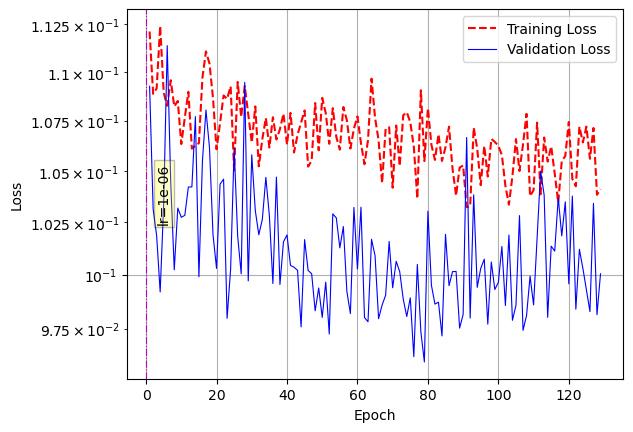

<Figure size 640x480 with 0 Axes>

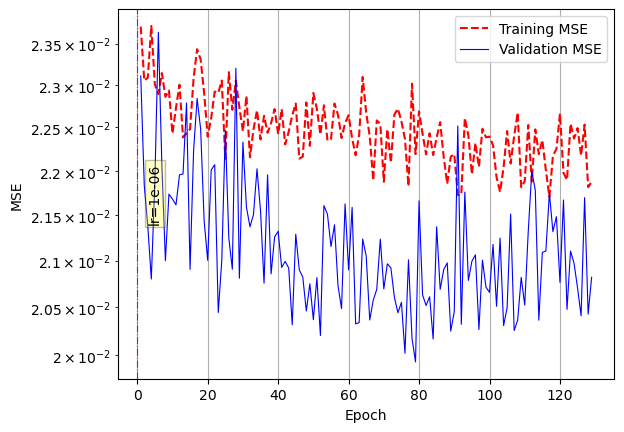

<Figure size 640x480 with 0 Axes>

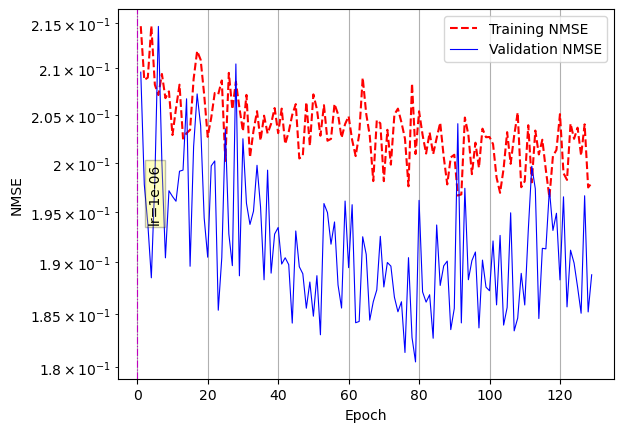

<Figure size 640x480 with 0 Axes>

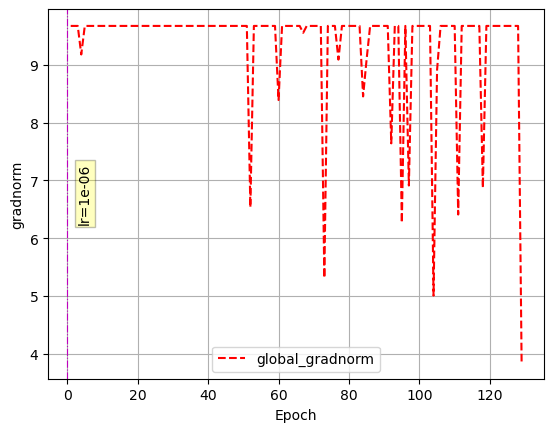

<Figure size 640x480 with 0 Axes>

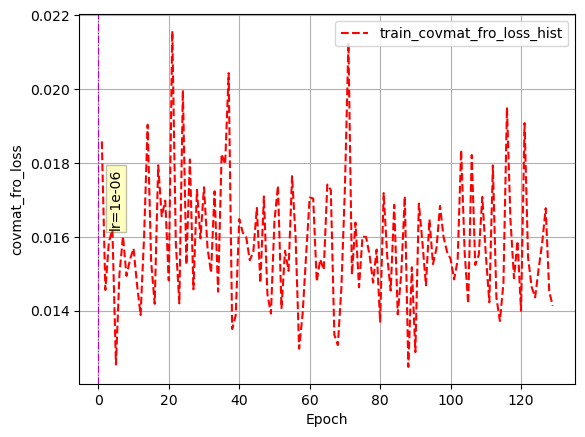

<Figure size 640x480 with 0 Axes>

In [23]:
global_clipnorm = None
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)
    if type(freeze_layers) == type(None):
        freeze_layers_thisoutstep = []
    else:
        if kk > len(freeze_layers) - 1:
            freeze_layers_thisoutstep = freeze_layers[-1]
        else:
            freeze_layers_thisoutstep = freeze_layers[kk]
        
        if type(freeze_layers_thisoutstep) == type(None):
            freeze_layers_thisoutstep = []

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    if behaviour == 'loadCheckpointAndContinueTraining':
        if kk < len(T_sample_output) - 1:
            temp = int((T_sample_output[kk+1] + 0.5*dt_rnn)//dt_rnn)
        else:
            temp = num_outsteps
        checkfile1 = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.hdf5'.format(temp)
        checkfile2 = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(temp)
        check1 = os.path.exists(checkfile1)
        check2 = os.path.exists(checkfile2)
        if check1 and check2:
            # move on to checking the next time-step
            continue
        else:
            pass
    
    print('clipnorm : {}, global_clipnorm : {}'.format(clipnorm, global_clipnorm))
    
    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN_ESN,
        all_data,
        AR_AERNN_ESN,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=[all_data.shape[0]],# boundary_idx_arr,
        delta_t=dt_rnn,#delta_t,
        # params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=False,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
        freeze_layers=freeze_layers_thisoutstep,
        clipnorm=clipnorm,
        global_clipnorm=global_clipnorm,
        ESN_flag=True,
        rnn_kwargs=rnn_kwargs,
    )
    
    wt_file_rnn = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.hdf5'.format(num_outsteps)
    wt_file_ae = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)
    
    with open(dir_name_ARrnn+'/final_net/losses-{}_outsteps.txt'.format(num_outsteps), 'r') as fl:
        lines = fl.readlines()

    loss_dict = eval(''.join(lines))
    train_global_gradnorm_hist = loss_dict['train_global_gradnorm_hist']
    # lr_change = loss_dict['lr_change']
    # trained_epochs = len(train_global_gradnorm_hist)
    # if lr_change[-1] - lr_change[-2] == epochs[kk][-1]:
    #     global_clipnorm = train_global_gradnorm_hist[-1]
    # else:
    #     global_clipnorm = train_global_gradnorm_hist[-patience[kk][-1]]

    # alpha1 = 0.9
    # alpha2 = 0.1
    # global_clipnorm = train_global_gradnorm_hist[0]
    # for i in range(1, len(train_global_gradnorm_hist)):
    #     global_clipnorm = alpha1*global_clipnorm + alpha2*train_global_gradnorm_hist[i]

    idxs_to_ignore = 0
    global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
    global_clipnorm = 0.9 * 0.25 * np.round(4*global_clipnorm)

In [24]:
batch_size*np.round(int(all_data.shape[0]*0.8)/batch_size)

26672.0

In [25]:
### Training the combined AE-RNN
# %pdb

In [26]:
normalization_constant_arr_aedata.shape

(2, 2, 50, 50)

# 